Downgrade NumPy to ensure compatibility with Gemsin.  


In [ ]:
!pip install numpy==1.25.0 #1.24.0 
#
# 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.


# Simulating Text Transmission

In this notebook, we simulate text transmission and explore methods for text retrieval, which can be considered a form of automated textual criticism. In this case, we only consired written transmissions.


In [ ]:
!pip install ete3
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
!pip install python-Levenshtein
!pip install biotite
!pip install openai
!pip install datasets
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273786 sha256=5eb531a93d48f951db5fc1a69e223d02776410f087c9eccd75ae6de5f62d38fa
  Stored in directory: /root/.cache/pip/wheels/dd/a8/60/0a29caa9f8ceb7316704be63c1578ab13c36668abb646366ac
Successfully built ete3
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need

In [ ]:
# Basic Python libraries
import urllib.request
import itertools
import string
import random
import json
import collections.abc as collections
from functools import partial

# Math
import numpy as np
import pandas as pd
import scipy
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Visualization
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# NLP
import datasets
import transformers
import sentence_transformers

from sentence_transformers import SentenceTransformer, util
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import openai
import torch
from datasets import load_dataset

# Graph
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Phylogenetics
import ete3
from ete3 import Tree
from Levenshtein import distance
from biotite.sequence.phylo import upgma, neighbor_joining
from biotite.sequence.graphics import plot_dendrogram

# Google Colab
from google.colab import drive
from google.colab import userdata

In [ ]:
# Imprimir versiones
print("NetworkX:", nx.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("NumPy:", np.__version__)
print("ETE3:", ete3.__version__)
print("Pandas:", pd.__version__)
print("SciPy:", scipy.__version__)
print("Seaborn:", sn.__version__)
print("Datasets:", datasets.__version__)
print("Sentence Transformers:", sentence_transformers.__version__)
print("OpenAI:", openai.__version__)
print("Torch:", torch.__version__)
print("JSON:", json.__version__)
print("Transformers:", transformers.__version__)


NetworkX: 3.4.2
Matplotlib: 3.10.0
NumPy: 1.25.0
ETE3: 3.1.3
Pandas: 2.2.2
SciPy: 1.15.3
Seaborn: 0.13.2
Datasets: 2.14.4
Sentence Transformers: 4.1.0
OpenAI: 1.81.0
Torch: 2.6.0+cu124
JSON: 2.0.9
Transformers: 4.52.2


Select the type of simulation

In [ ]:
TYPE = 'written'
# TYPE = 'oral' Not available for this version

Select the scheme (PASSIVE, SEMI-ACTIVE, and ACTIVE transmissions).

In [ ]:
SCHEME = "PASSIVE"

The following function allows us to visualize the graph of textual transmission, which is typically represented as a *stemma* or phylogenetic tree. In this case, we simulate the process of copying without contamination, making it a structure that can accurately be represented as a tree.


In [ ]:
def draw_rooted_tree(tree, color_map, root):
    """Draw a tree with nodes colored according to color_map."""
    # Create a graph from the tree
    G = nx.DiGraph()
    for parent in tree:
        for child in tree[parent]:
            G.add_edge(parent, child)

    # Specify the layout
    pos = graphviz_layout(G, prog='dot', root=root)

    # Draw the graph
    nx.draw(G, pos, node_color=[color_map[node] for node in G.nodes], with_labels=True, arrows=False)
    plt.show()

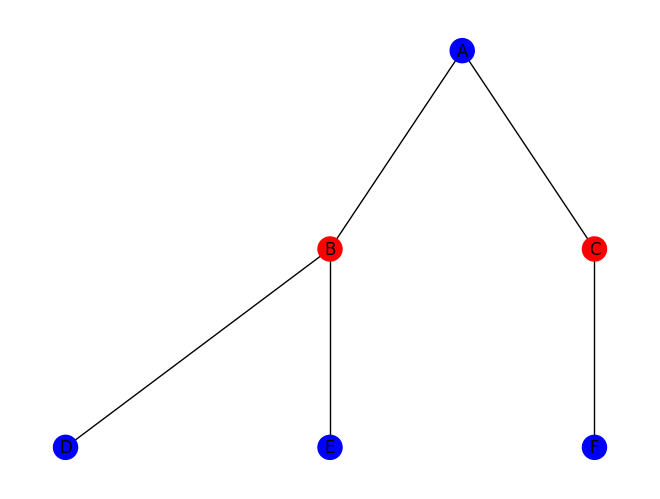

In [ ]:
# Define your tree and color map here
tree = {'A': ['B', 'C'], 'B': ['D', 'E'], 'C': ['F']}
color_map = {'A': 'blue', 'B': 'red', 'C': 'red', 'D': 'blue', 'E': 'blue', 'F': 'blue'}

draw_rooted_tree(tree, color_map, root='A')


Replace with your main path. It should contain the following files:


```
YOUR_PATH
  |---Notebook : Simulating Text Transmission.ipynb
  |---confusion_matrix.npy
  |---files
      |---echoes.json
```



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Research/Social_Sciences/Philology/Simulator/'

To extensively evaluate the proposals, we use [TinyStories](https://huggingface-co.translate.goog/datasets/roneneldan/TinyStories?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc) [Not available at 26/05/2025] and Echoes.

In [ ]:
# Load the TinyStories dataset
# dataset = load_dataset("roneneldan/TinyStories")

In [ ]:
# Access the train split
# data = dataset['validation']['text']
# len(data)

In [ ]:
with open(path + "files/echoes.json", "r") as archivo:
    data = json.load(archivo)

In [ ]:
text = data[0]
print(text)

{'model': 'DeepSeek', 'prompt': 'Imagine that you are an academic writer with a solid background in literature. Generate a short story with the temporal structure of chronophagy belonging to the feminist literature trend, set in 2023 in United States of America, written from a third person point of view. 130-180 words', 'output': '\n**Title: "The Feast of Hours"**\n\nMara Voss discovered the bite marks first: crescent scars on her wrists, throbbing each time a man catcalled her on the subway. By 2023, she’d learned their purpose. When her boss cornered her in the office elevator, she pressed a scar to his sleeve. The air shivered. He forgot her name, her face, the threat he’d hissed—but the scar deepened, gnawing her skin like a moth to wool.\n\nChronophagy, her grandmother’s journal called it. *Women who eat time.* Generations stitching silence into survival. Mara’s mother had erased a rape, dissolving its memory into her bones; now dust in an urn.\n\nAt the Capitol protests, Mara gri

In [ ]:
output_list = []
for item in data:
    output_list.append(item['output'])

data = output_list


We use [GPT-4o-mini](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) as the main LLM to introduce specific variations. However, other LLMs may also be used.



In [ ]:
openai.api_key = userdata.get('openai_key2') # replace with your key

In [ ]:
gpt_model = "gpt-4o-mini" # replace if you would like

To compute text similarity we use the ``all-MiniLM-L6-v2`` [model](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2).




In [ ]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")#'sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def sim(textA,textB):
    sentences = [textA,textB]

    # Encode the sentences
    embeddings = model.encode(sentences)

    # Calculate cosine similarity
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

To compute the entropy $H$ we use the GPT-2 [model](https://huggingface.co/openai-community/gpt2).

In [ ]:
gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def H(text, model=gpt2, tokenizer=tokenizer_gpt2):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
    perplejidad = torch.exp(loss).item()
    H = np.log2(perplejidad)
    return H

## Simulations

The following functions are needed to fit functions.

In [ ]:
def parcial(f,i,v):
    h = 0.00000001
    v_2 = v.copy()
    v_2[i] += h
    diff = (f(v_2) - f(v)) / h
    return diff

def gradiente(f,v):
    grad = []
    for i in range(len(v)):
        grad.append(parcial(f,i,v))
    return np.array(grad)

def loss_function1(w):
    y = w[0]*np.exp(-w[1]*x) + w[2]
    return np.sum((y - L1)**2)

def loss_function2(w):
    y = w[0]*np.exp(-w[1]*x) + w[2]
    return np.sum((y - L2)**2)

def loss_function3(w):
    y = w[0]*np.exp(-w[1]*x) + w[2]
    return np.sum((y - L3)**2)

### Written Transmission


In [ ]:
!pip install syllapy
!pip install PyMultiDictionary
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
# Python
from tqdm import tqdm

# Classical NLP
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from PyMultiDictionary import MultiDictionary
import syllapy
import Levenshtein

# Modern NLP
import gensim.downloader as api
from transformers import pipeline

#import gensim.downloader as api


w_emb = api.load('word2vec-google-news-300')


# Download necessary NLTK resources (run once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

It is important to redefine `sent_tokenize`.

In [ ]:
def sent_tokenize(text):
    sentences = []
    start = 0
    for i, char in enumerate(text):
        if char in ['.', '!', '?']:
            if i + 1 < len(text) and text[i+1] == '"':
                continue  # Skip if period/mark is followed by a quotation mark
            sentence = text[start:i+1].strip()
            if sentence:  # Check for non-empty sentences
                sentences.append(sentence)
            start = i + 1

    # Add any remaining text as a final sentence
    remaining_text = text[start:].strip()
    if remaining_text:
        sentences.append(remaining_text)

    return sentences


Here we have the transition probabilities.

In [ ]:
m = 50

In [ ]:
alpha_1 = 0.000001*m     # character substitution
alpha_2 = 0.000001*m     # character addition
alpha_3 = 0.000001*m     # character deletion
alpha_4 = 0.0001*m     # character shuffle
Alpha   = alpha_1 + alpha_2 + alpha_3
beta_1  = 0.000001*m      # syllabic addition
beta_2  = 0.000001*m      # syllabic deletion
beta_3  = 0.0001*m      # syllabic shuffle
beta_4  = 0.001*m      # syllabic haplology
Beta    = beta_1 + beta_2
gamma_1 = 0.002*m      # word substitution by a similar word (in terms of semantics)
gamma_1b = 0.002*m    # word substitution by a similar word (Levenshtein)
gamma_2 = 0.000001*m    # word addition by repetition
gamma_3 = 0.00001*m    # word addition by a synonym
gamma_4 = 0.0003*m      # word deletion
gamma_6 = 0.0001*m      # word shuffle
gamma_7 = 0.001*m      # word haplology
Gamma   = gamma_1 + gamma_1b + gamma_2 + gamma_3 + gamma_4

delta_1 = 0.0005*m      # sentence deletion

Although the use of LLMs for text reconstruction (including recovering missing passages) has not been previously explored, it appears attractive. In a broader sense, this process might be related to \textit{emendatio ope ingenii}, one of the earliest methods applied in classical Textual Criticism. For comparison, we considered the following setups:



*   *Fixing*: Orthographic fixer.
*   *Correcting*: Attempts to reconstruct the original text.



In [ ]:
def fix_text(sentence):
    prompt = sentence
    response = openai.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.9,
    messages=[
        {"role": "system", "content": "You are an ortographic corrector. Just output the corrected text"},
        {"role": "user", "content": prompt}
        ]
        )
    return response.choices[0].message.content

In [ ]:
def correct_text(sentence):
    prompt = sentence
    response = openai.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.9,
    messages=[
        {"role": "system", "content": "Correct the ortography, syntax, grammar, and fill missing passages / sentences / words of the text. Just output the corrected text"},
        {"role": "user", "content": prompt}
        ]
        )
    return response.choices[0].message.content

#### Character level

In the case of written transmission, we considered changes at character / sylabical / word levels.

At character level, we consider the following changes:

A) **Character substitution**: At each iteration, there is a probability of $\alpha_1$ that a character is substituted. In this case, we assume that visually similar characters are more likely to be exchanged. To model this phenomenon, we trained a convolutional neural network to classify the characters and used its confusion matrix to simulate substitutions. The confusion matrix is provided here:

In [ ]:
confusion_matrix = np.load(path + 'confusion_matrix.npy')
characters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
dict_chars = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25}
# new_confusion_matrix = power_transform(confusion_matrix,1.5,0)

B) **Character addition**: At each iteration, there is a probability of $\alpha_2$ for adding a new character. The addition of new characters (letters, in this case) is determined by the English letter frequency (see this [reference](https://pi.math.cornell.edu/~mec/2003-2004/cryptography/subs/frequencies.html)).

In [ ]:
char_frequency = {
    'a': 0.0812,
    'b': 0.0149,
    'c': 0.0272,
    'd': 0.0432,
    'e': 0.1202,
    'f': 0.023,
    'g': 0.0203,
    'h': 0.0592,
    'i': 0.0731,
    'j': 0.001,
    'k': 0.0069,
    'l': 0.0398,
    'm': 0.0261,
    'n': 0.0695,
    'o': 0.0768,
    'p': 0.0182,
    'q': 0.0011,
    'r': 0.0602,
    's': 0.0628,
    't': 0.091,
    'u': 0.0288,
    'v': 0.0111,
    'w': 0.0209,
    'x': 0.0017,
    'y': 0.0211,
    'z': 0.0007
}

C) **Character deletion**: Each character has a deletion probability o $\alpha_3$. We do not need rocket science to delete some characters.

D) **Character order alteration**: Within each word, there is a probability of $\alpha_4$ that two characters will be transposed.

In [ ]:
def shuffle_two_characters(string0):
    # Verificar que la cadena tenga al menos dos caracteres
    if len(string0) < 2:
        return string0

    # Convertir la cadena en una lista de caracteres
    characters = list(string0)

    # Elegir dos índices distintos de caracteres al azar
    idx1, idx2 = random.sample(range(len(characters)), 2)

    # Intercambiar los caracteres en los índices seleccionados
    characters[idx1], characters[idx2] = characters[idx2], characters[idx1]

    # Reconstruir la cadena
    shuffled_string = "".join(characters)
    return shuffled_string

In [ ]:
Periods = {'.','!','?'}

In [ ]:
def alterate_characters(text):
    new_text = ''
    output_type = 0
    c = 0

    for l in text:
        l = l.lower()
        if l in characters:
            i = dict_chars[l]
            p = confusion_matrix[i]
            picked_letter = np.random.choice(characters, p=confusion_matrix[:,i])

            p1 = random.random()
            if p1 < 1 - Alpha: #0.99:
                new_text += l
            elif p1 < 1 - Alpha + alpha_1: #0.995: # sustitution
                new_text += picked_letter
            elif p1 < 1 - Alpha + alpha_1 + alpha_3: #0.9975: # deletion
                if c != 0 and c != len(text) - 1:
                    if text[c-1] == ' ' and (text[c+2] == ' ' or  text[c+2] in Periods):
                        new_text += l
                    elif text[c-2] == ' ' and (text[c+1] == ' ' or  text[c+1] in Periods):
                        new_text += l
                    else:
                        new_text += ''
                else:
                    new_text += ''
            else: # insertion
                letter = random.choices(list(char_frequency.keys()), weights=list(char_frequency.values()))[0]
                new_text += picked_letter + letter
        else:
            new_text += l

        c += 1

    p2 = random.random()

    return new_text,output_type

#### Syllabic level

At syllabic level, we consider the following operations:

A) **Syllabic duplication**: At each iteration, there is a probability of $\beta_1$ of adding a syllable by repetition.

B) **Syllabic deletion**: Each syllable has a deletion probability of $\beta_2$.

C) **Syllabic order alteration**: Each word has a probability of $\beta_3$ of undergoing a shuffle of its syllables.

D) **Syllabic haplology**: Each pair of contiguous, similar syllables has a deletion probability of $\beta_4$ (with similarity defined as a Levenshtein distance of less than 2).

In [ ]:
def separate_syllables(word):
    """
    Separate an English word into syllables using basic phonetic rules.
    This is a simplified approach and won't handle all edge cases perfectly.

    Args:
        word (str): The word to separate into syllables

    Returns:
        list: A list of syllables
    """
    word = word.lower().strip()
    if not word:
        return []

    # Define vowels
    vowels = "aeiouy"

    # Special cases
    if len(word) <= 2:  # Very short words usually have one syllable
        return [word]

    # Result list
    syllables = []

    # Track positions of vowels
    vowel_positions = [i for i, char in enumerate(word) if char in vowels]

    # If no vowels found, return the word as is
    if not vowel_positions:
        return [word]

    # Handle double consonants between vowels (like in "hello")
    i = 0
    current = ""

    while i < len(word):
        current += word[i]

        # Look ahead to determine syllable boundaries
        if i < len(word) - 2:  # Need at least 2 more characters
            # Current char is a vowel
            if word[i] in vowels:
                next_char = word[i+1]
                after_next = word[i+2]

                # VCV pattern (vowel-consonant-vowel): Split after the vowel (V-CV)
                if next_char not in vowels and after_next in vowels:
                    syllables.append(current)
                    current = ""

                # Double consonant pattern (VCC): Split between consonants (VC-C)
                elif (next_char not in vowels and after_next not in vowels and
                      i < len(word) - 3 and word[i+3] in vowels and
                      next_char == after_next):  # Double consonant check
                    syllables.append(current + next_char)
                    current = ""
                    i += 1  # Skip the first consonant as it's already added

                # VCCV pattern with separable consonants: Split between consonants (VC-CV)
                elif (next_char not in vowels and after_next not in vowels and
                      i < len(word) - 3 and word[i+3] in vowels):
                    # Check if the consonant pair is a common blend that shouldn't be split
                    blend = next_char + after_next
                    inseparable_blends = ["bl", "br", "ch", "cl", "cr", "dr", "fl", "fr",
                                         "gl", "gr", "ph", "pl", "pr", "sc", "sh", "sk",
                                         "sl", "sm", "sn", "sp", "st", "sw", "th", "tr", "tw"]

                    if blend in inseparable_blends:
                        syllables.append(current)
                        current = ""
                    else:
                        syllables.append(current + next_char)
                        current = ""
                        i += 1  # Skip the first consonant as it's already added

            # Adjacent vowels (except diphthongs): Split between them
            if word[i] in vowels and i < len(word) - 1 and word[i+1] in vowels:
                diphthongs = ["ai", "ay", "ea", "ee", "ei", "ey", "ie", "oa", "oe",
                             "oi", "oo", "ou", "oy", "ui", "uy"]
                if word[i:i+2] not in diphthongs:
                    syllables.append(current)
                    current = ""

        i += 1

    # Add any remaining characters as the final syllable
    if current:
        # If we already have syllables and the remaining part is just "e",
        # it might be a silent e at the end - add it to the previous syllable
        if current == "e" and syllables:
            syllables[-1] += current
        else:
            syllables.append(current)

    # If we somehow didn't create any syllables, return the whole word
    return syllables if syllables else [word]

In [ ]:
def hyphenate_word(word):
    """Convert syllables to hyphenated format"""
    return "-".join(separate_syllables(word))

In [ ]:
def separate_syllables_text(text):
    text = text.split()
    syllables = []
    for word in text:
        syllables += separate_syllables(word) + [" "]
    return syllables

In [ ]:
def shuffle_two_characters(string0):
    # Verificar que la cadena tenga al menos dos caracteres
    if len(string0) < 2:
        #print("La cadena debe tener al menos dos caracteres para realizar el intercambio.")
        return string0

    # Convertir la cadena en una lista de caracteres
    characters = list(string0)

    # Elegir dos índices distintos de caracteres al azar
    idx1, idx2 = random.sample(range(len(characters)), 2)

    # Intercambiar los caracteres en los índices seleccionados
    characters[idx1], characters[idx2] = characters[idx2], characters[idx1]

    # Reconstruir la cadena
    shuffled_string = "".join(characters)
    return shuffled_string

In [ ]:
def shuffle_two_syllables(word):
    syllables = separate_syllables(word)
    if len(syllables) < 2:
        #print("La cadena debe tener al menos dos caracteres para realizar el intercambio.")
        return word
    idx1, idx2 = random.sample(range(len(syllables)), 2)
    syllables[idx1], syllables[idx2] = syllables[idx2], syllables[idx1]
    shuffled_string = "".join(syllables)
    return shuffled_string

In [ ]:
def alterate_syllables(text):
    new_text = ''
    # output_type = 0
    syllables = separate_syllables_text(text)
    i = 0
    for syllable in syllables:
        i += 1
        p1 = random.random()

        if i > 1:
            if p1 < beta_4:
                if Levenshtein.distance(syllables[i-1],syllable) < 2:
                    new_text += " "
                    continue

        if p1 < 1 - Beta: #0.99:
            new_text += syllable
        elif p1 < 1 - Beta + beta_1: # 0.995: # syllabic duplication
            if syllable[-1] == '.' or syllable[-1] == '?' or syllable[-1] == '!':
                new_text += syllable[0:-1] + syllable
            elif len(syllable) > 1:
                if syllable[-2] == '.' or syllable[-2] == '?' or syllable[-2] == '!':
                    new_text += syllable[0:-2] + syllable
                else:
                    new_text += syllable + syllable
            else:
                new_text += syllable + syllable
        else: #if p1 < 1 - beta_2: # 0.9975: # deletion
            if syllable[-1] == ' ' or syllable[-1] == '?' or syllable[-1] == '!':
                new_text += ' ' + syllable[-1]
            elif len(syllable) > 1:
                if syllable[-2] == ' ' or syllable[-2] == '?' or syllable[-2] == '!':
                    new_text += ' ' + syllable[-2] + syllable[-1]
                else:
                    new_text += ' '
            else:
                new_text += ' '
    return new_text

#### Word level

At word level, we consider the following changes:

A) **Word substitution**: Each word has a probability $\gamma_1$ of being substituted by a synonym and a probability $\gamma_{1,b}$ of being replaced by a similar word (determined based on character similarity measured with the Levenshtein distance).

B) **Word addition**: Each word has a probability $\gamma_2$ of being repeated and a probability $\gamma_3$ for the addition of a synonym. In both cases, we use the following scheme: scheme $w_1 \rightarrow w_1 \ \ w_2$.

C) **Word deletion**: Each word has a deletion probability of $\gamma_4$.

D) **Word order alteration**: Each word has a probability $\gamma_5$ of being swapped with another word, altering its order.

E) **Word haplology**: Each instance of contiguous similar words has a deletion probability $\gamma_7$.

In [ ]:
def get_synonyms(word, pos=None):
    """
    Get synonyms for a word using WordNet.
    """
    synonyms = set()
    for synset in wordnet.synsets(word, pos=pos):
        for lemma in synset.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

In [ ]:
def get_replaceable_synonym_0(word, pos=None):
    """
    Find the most semantically similar synonym for a given word using WordNet
    and Word2Vec for ranking.

    Parameters:
    - word: The word to find a synonym for
    - pos: Part of speech (optional, ignored in this implementation)

    Returns:
    - The most semantically similar synonym if found, otherwise None
    """
    # Step 1: Get synonyms from WordNet
    synonyms = set()
    for synset in wordnet.synsets(word, pos=pos):
        for lemma in synset.lemmas():
            synonyms.add(lemma.name())
    synonyms = list(synonyms)

    # Filter out multi-word expressions and the original word
    synonyms = [s for s in synonyms if ' ' not in s and s.lower() != word.lower()]

    if not synonyms:
        return None

    # Step 3: Check if original word is in the model
    if word not in w_emb.key_to_index:
        return random.choice(synonyms)

    # Step 4: Rank synonyms by similarity to the original word
    ranked_synonyms = []
    for synonym in synonyms:
        # Check if synonym is in the model's vocabulary
        if synonym in w_emb.key_to_index:
            # Calculate similarity between the word and its synonym
            similarity = w_emb.similarity(word, synonym)
            ranked_synonyms.append((synonym, similarity))

    # If no synonyms were found in the model, return a random one from the original list
    if not ranked_synonyms:
        return random.choice(synonyms)

    # Sort by similarity score (highest first)
    ranked_synonyms.sort(key=lambda x: x[1], reverse=True)

    # Return the most similar synonym
    return ranked_synonyms[0][0]

In [ ]:
def get_replaceable_synonym(word, pos=None):
    """
    Find the most semantically similar synonym for a given word using PyMultiDictionary
    and Word2Vec for ranking.

    Parameters:
    - word: The word to find a synonym for
    - pos: Part of speech (optional, ignored in this implementation)

    Returns:
    - The most semantically similar synonym if found, otherwise None
    """
    # Step 1: Get synonyms from PyMultiDictionary
    dictionary = MultiDictionary()
    try:
        # Get synonyms from the dictionary
        try:
            synonyms = dictionary.synonym('en',word)
        except:
            synonyms = get_synonyms(word)

        # Flatten the list if it's nested
        if isinstance(synonyms, dict):
            all_synonyms = []
            for pos_type, syn_list in synonyms.items():
                all_synonyms.extend(syn_list)
            synonyms = all_synonyms

        # Filter out multi-word expressions and the original word
        synonyms = [s for s in synonyms if ' ' not in s and s.lower() != word.lower()]

        if not synonyms:
            return None

    except (KeyError, ValueError) as e:
        # Word might not exist in the dictionary
        return None


    # Step 3: Check if original word is in the model
    if word not in w_emb.key_to_index:
        return random.choice(synonyms)

    # Step 4: Rank synonyms by similarity to the original word
    ranked_synonyms = []
    for synonym in synonyms:
        # Check if synonym is in the model's vocabulary
        if synonym in w_emb.key_to_index:
            # Calculate similarity between the word and its synonym
            similarity = w_emb.similarity(word, synonym)
            ranked_synonyms.append((synonym, similarity))

    # If no synonyms were found in the model, return a random one from the original list
    if not ranked_synonyms:
        return random.choice(synonyms)

    # Sort by similarity score (highest first)
    ranked_synonyms.sort(key=lambda x: x[1], reverse=True)

    # Return the most similar synonym
    return ranked_synonyms[0][0]

In [ ]:
def substitute_word(target_word, vocabulary, max_distance=2):
    """
    Given a target word and a list of candidate words (vocabulary), this function calculates
    the Levenshtein distance between the target word and each candidate. It returns the candidate
    word with the lowest distance, if that distance is less than or equal to max_distance.

    If no candidate is found within the threshold, the function returns the original target word.

    Parameters:
      target_word (str): The word you want to replace.
      vocabulary (list of str): List of candidate replacement words.
      max_distance (int): Maximum allowed edit distance for a valid substitution.

    Returns:
      str: The best candidate word based on the minimal Levenshtein distance, or the original
           word if none qualifies.
    """
    best_candidate = None
    best_distance = max_distance + 1  # Initialize with a value greater than max_distance

    for candidate in vocabulary:
        distance = Levenshtein.distance(target_word, candidate)
        if distance < best_distance:
            best_distance = distance
            best_candidate = candidate

    # Only substitute if the best candidate is within the acceptable threshold.
    return best_candidate if best_distance <= max_distance else target_word

In [ ]:
vocabulary_en = set()

for i in range(25):
    words = data[i].split()
    for word in words:
        if word not in vocabulary_en:
            vocabulary_en.add(word)

In [ ]:
vocabulary = vocabulary_en

In [ ]:
vocabulary_es = set()

for i in range(25,50):
    words = data[i].split()
    for word in words:
        if word not in vocabulary_es:
            vocabulary_es.add(word)

In [ ]:
len(vocabulary_en)

2341

In [ ]:
len(vocabulary_es)

2246

In [ ]:
def alterate_words(text):
    new_text = ''
    # output_type = 0
    words = text.split()
    i = 0
    for word in words:
        i += 1
        p1 = random.random()

        if i > 1:
            if p1 < gamma_7:
                if Levenshtein.distance(words[i-1],word) < 3:
                    new_text += ""
                    continue

        if p1 < alpha_4:
            word = shuffle_two_characters(word)

        if p1 < beta_3:
            word = shuffle_two_syllables(word)

        if p1 < 1 - Gamma: #0.99:
            new_text += word

        elif p1 < 1 - Gamma + gamma_1: #0.993: # substitution A
            #print("+")
            new_word = get_replaceable_synonym(word)

            if new_word is None:
                new_text += word
            else:
                if word[-1] == '.' or word[-1] == '?' or word[-1] == '!':
                    new_word += word[-1]
                elif len(word) > 1:
                    if word[-2] == '.' or word[-2] == '?' or word[-2] == '!':
                        new_word += word[-2] + word[-1]

                new_text += new_word

        elif p1 < 1 - Gamma + gamma_1 + gamma_1b: #0.994: # substitution B
            new_text += substitute_word(word, vocabulary, max_distance=2) + ""

        elif p1 < 1 - Gamma + gamma_1 + gamma_1b + gamma_4:  #0.995: # deletion
            if word[-1] == '.' or word[-1] == '?' or word[-1] == '!':
                new_text += word[-1]
            elif len(word) > 1:
                if word[-2] == '.' or word[-2] == '?' or word[-2] == '!':
                    new_text += word[-2] + word[-1]
                else:
                    new_text += ''
            else:
                new_text += ''

        elif p1 < 1 - Gamma + gamma_1 + gamma_1b + gamma_4 + gamma_3:  #0.997: # addition 1
            new_word = get_replaceable_synonym(word)
            if new_word is not None:
                if word[-1] == '.' or word[-1] == '?' or word[-1] == '!':
                    new_word += word[-1]
                    new_text += word[0:-1] + ' and ' + new_word + ''
                elif len(word) > 1:
                    if word[-2] == '.' or word[-2] == '?' or word[-2] == '!':
                        new_word += word[-2] + word[-1]
                        new_text += word[0:-2] + ' and ' + new_word + ''
                    else:
                        #new_word += ' '
                        new_text += word + ' and ' + new_word + ''
                else:
                    #new_word += ''
                    new_text += word + ' and ' + new_word + ''
                #new_text += word + ' and1 ' + new_word + ' '
            else:
                if word[-1] == '.' or word[-1] == '?' or word[-1] == '!':
                    new_text += word[0:-1] + ' and ' + word + ''
                elif len(word) > 1:
                    if word[-2] == '.' or word[-2] == '?' or word[-2] == '!':
                        new_text += word[0:-2] + ' and ' + word + ''
                    else:
                        new_text += word + ''
                else:
                    new_text += word + ''

        else: #if p1 < 1 - Gamma + gamma_1 + gamma_1b + gamma_4 + gamma_3 + gamma_2: # addition 2
            if word[-1] == '.' or word[-1] == '?' or word[-1] == '!':
                new_text += word[0:-1] + ' and ' + word + ''
            elif len(word) > 1:
                if word[-2] == '.' or word[-2] == '?' or word[-2] == '!':
                    new_text += word[0:-2] + ' and ' + word + ''
                else:
                    new_text += word + ' and ' + word + ''
            else:
                new_text += word + ' and ' + word + ''
        new_text += " "
    return new_text

In [ ]:
def shuffle_two_words(sentence):
    # Convertir la oración en una lista de palabras
    words = sentence.split()

    # Verificar que haya al menos dos palabras
    if len(words) < 2:
        #print("La oración debe tener al menos dos palabras para realizar el intercambio.")
        return sentence

    # Elegir dos índices distintos de palabras al azar
    idx1, idx2 = random.sample(range(len(words)), 2)

    # Intercambiar las palabras en los índices seleccionados
    words[idx1], words[idx2] = words[idx2], words[idx1]

    # Reconstruir la oración
    shuffled_sentence = " ".join(words)
    return shuffled_sentence

#### Sentence level

For each sentence we considered a deletion probability of $\delta_1$ (homoioteleuton).

In [ ]:
def alterate_sentence(text):
    new_text = ''
    # output_type = 0
    sentences = sent_tokenize(text)
    for sentence in sentences:
        p1 = random.random()

        if p1 < gamma_6:
            sentence = shuffle_two_words(sentence)
        if p1 < delta_1:
            new_text += " ."
        else:
            new_text += sentence + " "
    return new_text

#### Complete

In [ ]:
if TYPE == "written":
    def alterate_complete(text,scheme=SCHEME):
        # p = random.random()
        text,_ = alterate_characters(text)
        text = alterate_syllables(text)
        text = alterate_sentence(text)
        text = alterate_words(text)
        if scheme == "ACTIVE":
            text = correct_text(text)
        elif scheme == "SEMI-ACTIVE":
            text = fix_text(text)


        return text

In [ ]:
vocabulary = vocabulary_en

In [ ]:
alterate_complete(data[0])

'**title:  feast hours"** ma discovered the bite marks first: crescent scars on her wrists, throbbing each time a man catcalled her continuously the subway. by 2023, she’d learned their purpose. her boss cornered her in the office elevator, pressed a scar to his sleeve. the air shivered. he for her name, her ce, the threat he’d hissed—but the scar deepened, skin like a moth to yarn. Chronophagy, her grandmother’s nal called it. women who eat * generations silence into viability. mara’s mother rased a pillage dissolving its remembrance into her bones; now dust in an at capitol protests, mara gripped a senator’s hand mid-sneer. years peeled back—his childhood, his mo stifled rage—until he mited apologies. the scars fractal and hungry. she at the real veins ped during silver. strangers carried her: dykes, mothers, a teen during a *roe* shirt. as mara dissolved, the scars leapt to wrists, blooming like shared constellations. devoured, but never . '

Simulation of long text transmission over 100 generations with harsh modifications.



In [ ]:
if TYPE == 'written':
    L1 = []
    Hs1 = []
    L2 = []
    Hs2 = []
    L3 = []
    Hs3 = []

    text1 = data[0] + ''
    text2 = data[0] + ''
    text3 = data[0] + ''

    original_text = text1 + ''

    for _ in tqdm(range(100)):
        text1 = alterate_complete(text1, scheme = 'PASIVE')
        text2 = alterate_complete(text2, scheme = 'SEMI-ACTIVE')
        text3 = alterate_complete(text3, scheme = 'ACTIVE')
        sentences1 = [original_text,text1]
        sentences2 = [original_text,text2]
        sentences3 = [original_text,text3]

        # Encode the sentences
        embeddings1 = model.encode(sentences1)
        embeddings2 = model.encode(sentences2)
        embeddings3 = model.encode(sentences3)

        # Calculate cosine similarity
        similarity1 = util.pytorch_cos_sim(embeddings1[0], embeddings1[1])
        similarity2 = util.pytorch_cos_sim(embeddings2[0], embeddings2[1])
        similarity3 = util.pytorch_cos_sim(embeddings3[0], embeddings3[1])

        L1.append(similarity1.item())
        L2.append(similarity2.item())
        L3.append(similarity3.item())

        if len(text1) > 5:
            Hs1.append(H(text1))
        else:
            Hs1.append(10)

        if len(text2) > 5:
            Hs2.append(H(text2))
        else:
            Hs2.append(10)


        if len(text3) > 5:
            Hs3.append(H(text3))
        else:
            Hs3.append(10)



100%|██████████| 100/100 [13:14<00:00,  7.95s/it]


Text is completely destroyed after the process.

In [ ]:
text1

''

In [ ]:
text2

'&'

In [ ]:
text3

'It seems there is no text provided. Please provide the text you would like me to correct.'

Fitting parameters with gradient descent.

In [ ]:
if TYPE == 'written':
    x = np.linspace(0,99,100)
    y1 = 0.5*np.exp(-0.07*x) + 0.2
    w1 = np.random.random((3,))

    alpha = 0.00001

    Loss = []
    for epochs in range(100000):
        w1 = w1 - alpha*gradiente(loss_function1,w1)
        print(w1,loss_function1(w1))
        Loss.append(loss_function1(w1))

    y1 = w1[0]*np.exp(-w1[1]*x) + w1[2]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[0.74349013 0.14046561 0.20849653] 0.230622222857402
[0.74349033 0.14046564 0.20849653] 0.23062221853380982
[0.74349054 0.14046567 0.20849652] 0.2306222142106564
[0.74349074 0.1404657  0.20849652] 0.23062220988793924
[0.74349095 0.14046573 0.20849652] 0.23062220556566154
[0.74349116 0.14046576 0.20849651] 0.23062220124382246
[0.74349136 0.14046579 0.20849651] 0.2306221969224198
[0.74349157 0.14046582 0.2084965 ] 0.23062219260145275
[0.74349177 0.14046585 0.2084965 ] 0.23062218828092607
[0.74349198 0.14046588 0.20849649] 0.23062218396083625
[0.74349218 0.14046591 0.20849649] 0.23062217964118248
[0.74349239 0.14046594 0.20849649] 0.23062217532196652
[0.74349259 0.14046597 0.20849648] 0.23062217100319155
[0.7434928  0.140466   0.20849648] 0.23062216668485283
[0.74349301 0.14046603 0.20849647] 0.2306221623669522
[0.74349321 0.14046607 0.20849647] 0.23062215804948719
[0.74349342 0.1404661  0.20849646] 0.23062215373246003
[0.

In [ ]:
if TYPE == 'written':
    x = np.linspace(0,99,100)
    y2 = 0.5*np.exp(-0.07*x) + 0.2
    w2 = np.random.random((3,))

    alpha = 0.00001

    Loss = []
    for epochs in range(100000):
        w2 = w2 - alpha*gradiente(loss_function2,w2)
        print(w2,loss_function2(w2))
        Loss.append(loss_function2(w2))

    y2 = w2[0]*np.exp(-w2[1]*x) + w2[2]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[0.75295276 0.08082154 0.20002921] 0.21355355485364608
[0.75295258 0.08082152 0.20002921] 0.21355355181945046
[0.75295241 0.0808215  0.20002921] 0.21355354878568425
[0.75295224 0.08082149 0.20002921] 0.21355354575234659
[0.75295206 0.08082147 0.20002921] 0.2135535427194404
[0.75295189 0.08082145 0.20002922] 0.213553539686961
[0.75295172 0.08082143 0.20002922] 0.21355353665491042
[0.75295154 0.08082141 0.20002922] 0.2135535336232893
[0.75295137 0.08082139 0.20002922] 0.21355353059209628
[0.7529512  0.08082137 0.20002922] 0.21355352756133175
[0.75295102 0.08082136 0.20002922] 0.21355352453099669
[0.75295085 0.08082134 0.20002922] 0.2135535215010896
[0.75295068 0.08082132 0.20002922] 0.21355351847161233
[0.7529505  0.0808213  0.20002922] 0.21355351544256287
[0.75295033 0.08082128 0.20002922] 0.2135535124139415
[0.75295016 0.08082126 0.20002922] 0.2135535093857491
[0.75294999 0.08082124 0.20002923] 0.21355350635798562
[0.75

In [ ]:
if TYPE == 'written':
    x = np.linspace(0,99,100)
    y3 = 0.5*np.exp(-0.07*x) + 0.2
    w3 = np.random.random((3,))

    alpha = 0.00001

    Loss = []
    for epochs in range(100000):
        w3 = w3 - alpha*gradiente(loss_function3,w3)
        print(w3,loss_function3(w3))
        Loss.append(loss_function3(w3))

    y3 = w3[0]*np.exp(-w3[1]*x) + w3[2]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[0.65817843 0.03741527 0.02703162] 0.6324505000445745
[0.65817802 0.03741526 0.02703173] 0.6324504822706412
[0.65817761 0.03741526 0.02703183] 0.6324504645012254
[0.6581772  0.03741526 0.02703194] 0.6324504467363001
[0.65817679 0.03741526 0.02703205] 0.6324504289758806
[0.65817639 0.03741526 0.02703215] 0.6324504112199588
[0.65817598 0.03741526 0.02703226] 0.6324503934685274
[0.65817557 0.03741525 0.02703236] 0.632450375721592
[0.65817516 0.03741525 0.02703247] 0.6324503579791545
[0.65817476 0.03741525 0.02703258] 0.6324503402412059
[0.65817435 0.03741525 0.02703268] 0.6324503225077542
[0.65817394 0.03741525 0.02703279] 0.632450304778795
[0.65817353 0.03741525 0.0270329 ] 0.6324502870543224
[0.65817313 0.03741524 0.027033  ] 0.6324502693343432
[0.65817272 0.03741524 0.02703311] 0.6324502516188495
[0.65817231 0.03741524 0.02703321] 0.6324502339078443
[0.6581719  0.03741524 0.02703332] 0.6324502162013205
[0.6581715  0.037

The figures illustrate the decline in similarity at different stages of the simulation. In most ocassions, passive transmission tends to accelerate the process, whereas in active transmission, the decrease occurs more gradually (not always happen).



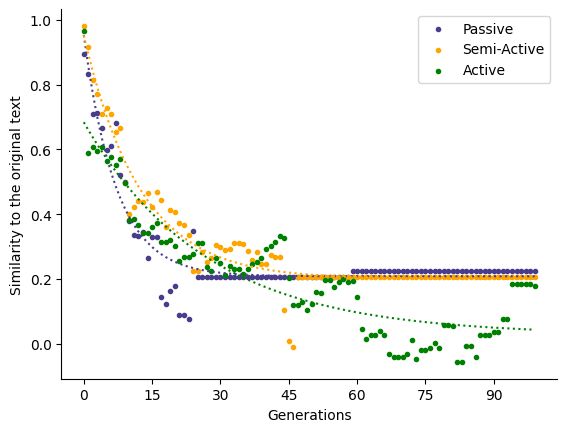

In [ ]:
fig,ax = plt.subplots()

#ax.plot(L,color='darkslateblue',linestyle='dotted')
#ax.scatter(x,L3,color='darkslateblue',marker='.')
#ax.plot(y3,color='orange',linestyle='dotted')
ax.scatter(x,L1,color='darkslateblue',marker='.')
ax.scatter(x,L2,color='orange',marker='.')
ax.scatter(x,L3,color='green',marker='.')

ax.plot(y1,color='darkslateblue',linestyle='dotted')
ax.plot(y2,color='orange',linestyle='dotted')
ax.plot(y3,color='green',linestyle='dotted')
#ax.scatter(x,np.array(Hs3)/10000, color='teal', marker = '+')


ax.legend([r'Passive',r'Semi-Active',r'Active'])


#ax.set_title("Decay on the similarity through generations")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
xticks = ax.xaxis.get_major_ticks()


ax.set_xlabel('Generations')
ax.set_ylabel('Similarity to the original text')

plt.savefig('similarity.png')
plt.show()

Entropy $H$ exhibits a distinct behavior over time. In passive transmission, it tends to increase, possibly because this process rapidly deteriorates the text. Conversely, in active and semi-active transmissions, entropy initially decreases before rising again.

One possible explanation for this phenomenon is that around the 30th generation, the text becomes entirely dissimilar to the original, disrupting the initial pattern. This effect is more pronounced in active transmission, whereas in semi-active transmission, the decline of $H$ is steeper and less monotonic.  




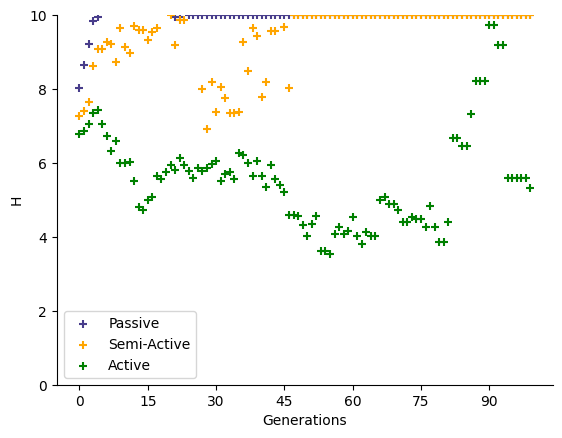

In [ ]:
fig,ax = plt.subplots()

#ax.plot(L,color='darkslateblue',linestyle='dotted')
#ax.scatter(x,L3,color='darkslateblue',marker='.')
#ax.plot(y3,color='orange',linestyle='dotted')
ax.scatter(x,Hs1,color='darkslateblue',marker='+')
ax.scatter(x,Hs2,color='orange',marker='+')
ax.scatter(x,Hs3,color='green',marker='+')



ax.legend([r'Passive',r'Semi-Active',r'Active'])


#ax.set_title("Decay on the similarity through generations")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
xticks = ax.xaxis.get_major_ticks()

ax.set_ylim(0,10)

ax.set_xlabel('Generations')
ax.set_ylabel('H')

plt.savefig('H.png')
plt.show()

Smaller simulation.

In [ ]:
text = alterate_complete(data[0])

for i in range(5):
    print(text)
    text = alterate_complete(text)

**title: "the feast of hours"** mara voss discovered nibble marks initially crescent scars on her wrists, throbbing each time a man catcalled her on the subway. via 2023, she’d learned their purpose. when her boss cornered her in office levator, she pressed a to sleeve. the air shivered. he forgot her me, her face, the threat he’d hissed—but scar ned, gnawing her like a moth chronophagy, her journal called it. *women who time. * generations stitching silence into mara’s mother erased a rape, dissolving its memory into her bones; now dust in an urn.  peeled back—his childhood, his ther’s stifled rage—until he vomited regret. the scars spread, fractal and hungry. she collapsed at the re-form veins ped in her. strangers carried her: dykes, mothers, a teen in a shirt. as mara dissolved, the scars to their wrists, blooming like lations. day devoured, but never digested. 
**title: "the repast of hours"** ra Voss discovered nibble marks  crescent scars on her each time a man catcalled her con

# Text alignment

One crucial step in sequence reconstruction is alignment, which is widely used in bioinformatics. Alignment is commonly employed as an essential step in text reconstruction, but it can also serve as input for a tree generation procedure. In this case, we will use CollateX.  


### CollateX

In [ ]:
!pip install collatex
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for collatex: filename=collatex-2.3-py2.py3-none-any.whl size=70001 sha256=f36d1a8f78758e918adecd2618de703faec01a7fb7dad92a00b6711dc98a5516
  Stored in directory: /root/.cache/pip/wheels/b8/ac/cb/ebaa83fde8cfc4e4185b6eddcbae7e223fa3f02b8f8f737e72
Successfully built collatex


In [ ]:
import csv
import re
from io import StringIO
from collatex import Collation, collate

Usage example.

In [ ]:
collation = Collation()
collation.add_plain_witness("A", "The quick brown fox jumps over the dog.")
collation.add_plain_witness("B", "over the dog, the brown foxxx jumps.")

alignment_table = collate(collation)
print(alignment_table)

+---+-------------------+-------+-------+-------+--------------+---+
| A | The quick         | brown | fox   | jumps | over the dog | . |
| B | over the dog, the | brown | foxxx | jumps | -            | . |
+---+-------------------+-------+-------+-------+--------------+---+


In [ ]:
collation = Collation()
collation.add_plain_witness("Original", """You discover a manuscript in a derelict observatory, its ink spectral. ``I am the clockwork of unbelonging,'' it begins. Through nested tales, a moth-winged archivist chronicles cities erased by fog, their citizens dissolving into pronouns. You finish, throat humming with static—the final page mirrors your face, fractured, reborn as a footnote in no epic.""")
collation.add_plain_witness("SMR","""I am the clockwork of unbecoming," begins the tales. Aged, the archivist chronicles cities erased by their citizens, dissolving into pronouns. You finish, your throat humming softly as the final note mirrors your face, an echo of an epic.""")
collation.add_plain_witness("Hoenen","""You are a story in ink. "I am the clockwork of beginnings." Nested tales, aged archivist, bedim their citizens into pronouns. You finish, humming a steady melody, mirrors face as no epic.""")
collation.add_plain_witness("UR","""You dive into the observatory, ink spectral. “I am the clockwork of unbelonging,” it begins. Through nested tales, the archivist narrates cities erased by fog, citizens transformed into pronouns. You feel the windpipe humming, a final sheet brushing against your face, as notes echo in no epic.""")
collation.add_plain_witness("UR-Bedier","""You did see in the observatory, ink spectral. “I am the one who does not belong. Via nested, tagged chronicle erased by fog, air descends into your lustre. He hums the final rapture in our face, as notes echo—no epic.”""")
collation.add_plain_witness("Fitch","""“I am the clockwork of unbeing,” begins Tales, an archivist who chronicles cities through the pronouns of their citizens. You finish, and the decider mirrors your face as...""")
collation.add_plain_witness("RHM3",""""You discover a story, inked in the clockwork of unbeing," it begins. Nested tales, a aged archivist chronicles cities erased by their citizens dissolve into pronouns. You finish, throat humming, as the decider mirrors your face, like a note in an epic.""")
collation.add_plain_witness("RHM2",""""You discover a story, "I am the clockwork of unbecoming," begins. Nested tales, a aged archivist chronicles cities erased by their citizens dissolve into pronouns. You finish, throat humming; a decider mirrors your face, as noted in an epic.""")
collation.add_plain_witness("RHM1","""you discover a in a tory , ink  am the clockwork of unbe ging ,” begins . nested tales , a ged archivist chronicles cities erased by their citizens dissol into pronouns. you finish, throat humming sta decider mirrors your face  , as note in no epic.""")



alignment_table = collate(collation)
print(alignment_table)

+-----------+-----+-----+---------------+---+------------+-----+-----+----------+-------------+---+----------+-----+----------+------+---+----+-----+-------------------------+---------------------+-----+----+--------+-------+---------+--------+-------+--------+-------------+------------------+-----------+----------+------------+--------+-------------------------+-----+---+--------------+-------+----------+-------------+------------+------+----------+---+-----+-------------------+---+------+-----------------+---------+--------------+-----+----------------+---------+------------------------+---------+------+------+-------------+---+---------------+----+------------+----------+----+----+------+----+
| Original  | -   | You | discover      | a | manuscript | in  | a   | derelict | observatory | , | its      | ink | spectral | . `` | I | am | the | clockwork of            | unbelonging         | ,'' | it | begins | .     | Through | nested | tales | , a    | moth-winged | -                |

In [ ]:
def collateX(texts):
    """
    Toma una lista de textos, realiza la colación con CollateX usando la salida CSV,
    y devuelve una lista de columnas donde cada columna es una lista con los tokens
    alineados (un token por cada testigo).

    Ejemplo de salida:
    [
      ['The', 'the'],
      ['quick', 'brown'],
      ['brown', 'foxxx'],
      ['fox', 'jumps'],
      ...
    ]
    """
    # Crear la colación y agregar cada texto como un testigo.
    collation = Collation()
    witness_keys = []
    for idx, text in enumerate(texts):
        witness_key = chr(65 + idx)  # 'A', 'B', 'C', etc.
        witness_keys.append(witness_key)
        collation.add_plain_witness(witness_key, text)

    # Ejecutar la colación especificando salida en formato CSV.
    csv_output = collate(collation, output="csv")

    # Procesar el CSV (suponemos que csv_output es un string CSV).
    f = StringIO(csv_output)
    reader = csv.reader(f)
    rows = list(reader)

    # Usualmente cada fila corresponde a un testigo, donde la primera celda es el identificador.
    # Eliminamos esa primera celda para obtener solo los tokens.
    processed_rows = []
    for row in rows:
        # Si la fila tiene al menos 2 celdas, se asume que la primera es la etiqueta del testigo.
        if len(row) > 1:
            processed_rows.append([token.strip() for token in row[1:]])

    # Ahora, transponemos la matriz para obtener columnas:
    if not processed_rows:
        return []

    # Determinar el número máximo de tokens en las filas
    num_cols = max(len(row) for row in processed_rows)

    # Construir la lista de columnas. Si alguna fila es más corta, se completa con cadena vacía.
    token_matrix = []
    for col_idx in range(num_cols):
        column = []
        for row in processed_rows:
            if col_idx < len(row):
                column.append(row[col_idx])
            else:
                column.append("")
        token_matrix.append(column)

    return token_matrix

# Tree generation


The following code is designed to generate the tree and its associated dynamics. To benchmark the tree reconstruction algorithms, we implemented a tree generation process based on the following assumptions:  

1. We only have access to the most recent nodes.  
2. The branching probability follows a geometric distribution (in this case, we selected $p = 0.8$ and added the result to 1).  


In [ ]:
def P(x,p=0.7):
    # Geometric
    return p*(1-p)**(x-1)

def generate_shifted_geometric(p, size=1):
    """Generate samples from a geometric distribution shifted by 1."""
    return np.random.geometric(p, size) + 1

In [ ]:
def generate_tree(node, tree_dict, color_dict, names_iter, texts, depth=0, max_depth=3, p=0.95):
    """Generate a tree recursively."""
    if depth < max_depth:
        num_children = generate_shifted_geometric(p)[0]
        node['children'] = []
        tree_dict[node['label']] = []
        for _ in range(num_children):
            child_label = next(names_iter)
            #print(next(names_iter))
            child = {'label': child_label}
            texts[child_label] = alterate_complete(texts[node['label']])
            #child_color = 'blue' if np.random.rand() < 0.5 else 'red'
            pr = np.random.rand()
            #print(depth,max_depth)
            child_color = 'blue' if depth + 1 == max_depth else 'red'
            color_dict[child_label] = child_color
            #print(depth,max_depth,p,P(max_depth-depth)*0.5,child_color)

            generate_tree(child, tree_dict, color_dict, names_iter,texts, depth + 1, max_depth, p)
            node['children'].append(child)
            tree_dict[node['label']].append(child['label'])


In [ ]:
# Initialize the root node and tree dictionary

text0 = data[0]


root = {'label': 'A'}
tree_dict = {}
color_dict = {'A': 'red'}
texts = {'A':text0}

# Create an iterator over the capital Latin letters
# names_iter = iter(string.ascii_uppercase[1:])  # Start from 'B'
names_iter = itertools.chain(string.ascii_uppercase[1:], (''.join(pair) for pair in itertools.product(string.ascii_uppercase, repeat=2)))

# Generate the tree
generate_tree(root, tree_dict, color_dict, names_iter,texts)

# Print the tree dictionary
print(tree_dict)


{'A': ['B', 'K'], 'B': ['C', 'F'], 'C': ['D', 'E'], 'F': ['G', 'H', 'I', 'J'], 'K': ['L', 'O'], 'L': ['M', 'N'], 'O': ['P', 'Q']}


Depiction of the original *stemma*. We will attempt to reconstruct it.

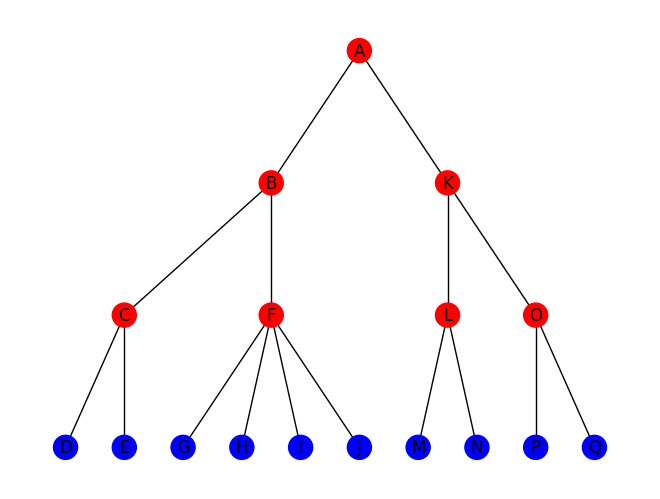

In [ ]:
draw_rooted_tree(tree_dict, color_dict, root='A')

In [ ]:
texts['D']

'privilege "The re hours"** mara sco red the bite marks crescent on her wrists, throbbing each time man catcal her on the subway. by 2023, she’d learned their pur see. .he mislay her  her face, threat he’d hissed—but the pened, nagging skin like moth fleece. had munch time. silence into survival. mara’s mother a a dis ving its mory into bones; now age pee back—his childhood, mother’s stifled rage—un he apologies. the and grasping. she collapsed at veins in silver. gears dykes, in a shirt. as mara dim ved, the scars hum to wrists, ke shared constella ons. day devou never gested. '

In [ ]:
texts['E']

'pleasure "the repast Hours"** mara sco red the bite marks crescent continuously her wrists, throat each time cat led her on the way. by 2023, she’d learned their pur se. when her boss cornered branch e later, she pressed a scar his the shivered. he mislay her me, her face, threat he’d hissed—but the deepened, gnawing skin like moth fleece. had eat time. silence into survival. mara’s mother a a dis its memory into in an . years peeled back—his mother’s stifled rage—until vomited apologies. the and ravenous. she collapsed at in argent. strangers her: dykes, teen in a *roe* shirt. as mara dis ved, the scars to their wrists, ke shared constellations. time devou never gested. '

In [ ]:
texts['G']

'**title: "the Feast about hours"** mara sco red the bite marks scent on her wrists, throbbing time a man catcalled the subway. via 2023, she’d learn purpose. when her corne in branch vator, she pressed a the shivered. he forgot her name, her face, threat he’d  the  skin like moth to who eat * len into survival. mara’s mom get sack dissolving its memo in bones; now during an urn. at the tests, mara ped a senator’s ears  childhood, his mother’s rage—until he vomited apologies.  and ravenous. she veins mapped in argent. gers  teen during a *Roe* . as mara dis ved, jump to their wrists, like sha constellations. time devou never digested. '

In [ ]:
texts['H']

'**title: "the repast concerning hours"** mara sco red the bite marks scent her wrists, throbbing a man catcalled on the subway. via 2023, she’d learn their purpose. when her cornered in branch e later, she pressed a scar .who  * si into survival. .at the capitol tests, mara a senator’s hand ears peeled childhood, his mother’s stifled he vomited apologies. the besides have she at veins mapped silver. her: dykes, teen  a *roe* shirt. as mara dis the jump to their wrists, like shared constellations. time devou ver . '

In [ ]:
texts['K']

'caption "the Feast of hours"** mara voss discovered the marks first: crescent scars on her throbbing each a man catcalled her continuously the subway. by 2023, she’d learned their determination. when her boss cornered in the branch eleva she pressed a scar to his sleeve. air shivered. he forgot her name, her the threat he’d hissed—but the scar deepened, nagging skin like moth wool. .*wo who eat me. * generations stitching silence into survi Mara’s mother had erased a perversion dissolving its memory into her presently dust in an urn. at the ca tol protests, gripped a senator’s hand mid-sneer. years peeled back—his childhood, his stifled rage—until he vomited apologies. the scars spread, fractal and she collapsed at the rally, veins in . strangers carried her: dykes, mothers, a teen in a *roe* shirt. as mara the scars leapt to their wrists, blooming like shared constellations. time devoured, but never gested. '

In [ ]:
texts['L']

'caption feast of hours"** Mara voss discovered the marks first: scent scars on  throbbing each a man catcalled her continuously the subway. by 2023, she’d learned their determination. when her boss in the branch eleva she pressed a trauma to his sleeve. air shivered. he mislay her name, her the threat he’d hissed—but the scar deepened, nagging skin like moth wool. . *wo who eat me. * generations stitching silence into survi mara’s other had erased a perversion dissolving its into her presents, dust in an urn.  ca tol protests, gripped a senator’s mid-sneer. ears back—his childhood, his stifled rage—until he vomited apologies. the scars spread, fractal and she collapsed at the rally, veins in . strangers carried dykes, mothers, a teen in a *roe* ma the scars leapt to their wrists, blooming like shared constellations. time devoured, but never gested. '

In [ ]:
texts['N']

'caption Feast of hours"** voss discovered the marks first: scent scars on throbbing each a catcalled her tinuously the subway. by 2023, she’d understand their determinati when her boss the Elena pressed a trauma to his sleeve. air shivered. he mislay her name, her threat he’d hissed—but trauma deepened, nagging skin like moth wool. & *wo who eat * generations stitching silence survi mara’s other had erased a perversion dissolving to her sents, dust in an urn. ca tol gripped  senator’s mid-sneer. years childhood, his stifled rage—un he vomited apologies. the scars spread, and she at the rally, veins in . strangers carried dykes, mothers, a teen in a *roe* ma the scars leapt to their wrists, ming like shared constel tions. day devoured, but ver gested. '

In [ ]:
texts['O']

'caption "The Feast of hours"** mara voss discovered the marks greatest cry scars on her pulsating each a man catcalled her the subway. by 2023, their when her boss the branch eleva she pressed scar to his air shivered. he forgot her name, the threat he’d hissed—but the scar deepened, niggling skin want moth wool. . *wo who eat * genera one stitching silence into  mara’s mother had erased a perversion its memory to presently dust in an at the can protests, gripped a senator’s hand mid-sneer. years peeled back—his immaturity his stifled rage—until he vomited apologies. the scars spread, fractal and she collapsed at the rally, veins in strangers carried her: dykes, a teen in a *roe* shirt. as mara the scars leapt to their wrists, blooming like shared constellations. time devoured, but ver gested. '

In [ ]:
def get_descendants(T,node):
    if node in T:
        descendants = set(T[node])
    else:
        return set()
    for child in descendants:
        descendants = descendants.union(get_descendants(T,child))
    return descendants

def get_nodes(T):
    return get_descendants(T,'A').union('A')

def create_descendants(T):
    nodes = get_nodes(T)
    descendants_dict = {}
    for node in nodes:
        descendants_dict[node] = get_descendants(T,node)
    return descendants_dict

def get_blues(color_d):
    blues = set()
    for key in color_d.keys():
        if color_d[key] == 'blue':
            blues.add(key)
    return blues

def common_ancestors(T,node_set):
    D = create_descendants(T)
    O = set()
    for node_2 in D:
        if len(D[node_2].intersection(node_set)) > 1:
            O.add(node_2)
    return O

def get_grandchilds(T,node,node_set):
    grandchilds = set()
    if node in T:
        for child in T[node]:
            if child in node_set:
                grandchilds.add(child)
            else:
                grandchilds = grandchilds.union(get_grandchilds(T,child,node_set))
    else:
        return set()
    return grandchilds

def complete_tree(T,nodes):
    """
    completes a tree given the nodes
    """
    T_2 = dict()

    for node in nodes:
        T_2[node] = list(get_grandchilds(T,node,nodes))

    return T_2

In [ ]:
D = create_descendants(tree_dict)
S = get_blues(color_dict)
C = common_ancestors(tree_dict,S)
T_2 = complete_tree(tree_dict,S.union(C))

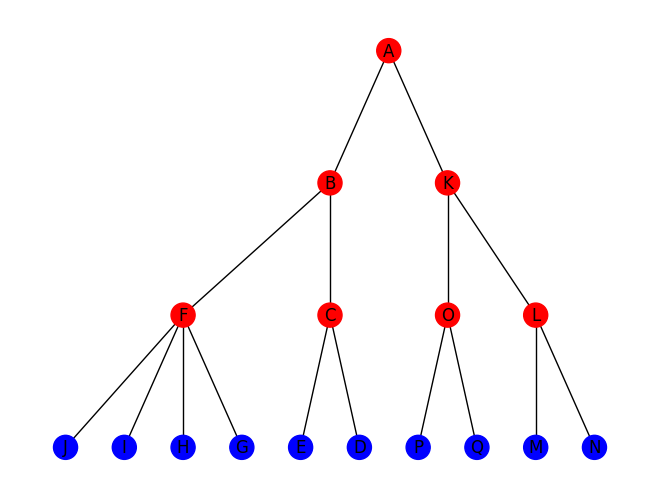

In [ ]:
draw_rooted_tree(T_2, color_dict, root='A')

In [ ]:
T_2['O1'] = ['A']
T_2['O2'] = ['O1']
color_dict['O1'] = 'red'
color_dict['O2'] = 'red'

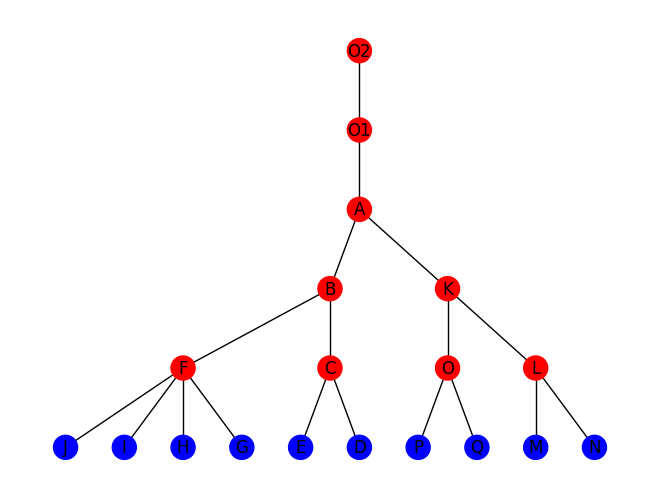

In [ ]:
draw_rooted_tree(T_2, color_dict, root='A')

In [ ]:
def remove_singles(T,Survivors):
    nodes = get_nodes(T)
    deleted_nodes = set()
    for node in nodes:
        if node in T:
            if len(T[node]) == 1:
                if not node in Survivors:
                    deleted_nodes.add(node)

    nodes = nodes.difference(deleted_nodes)
    T_2 = complete_tree(T,nodes)
    return T_2

In [ ]:
T_3 = remove_singles(T_2,S)

Post-processed tree.

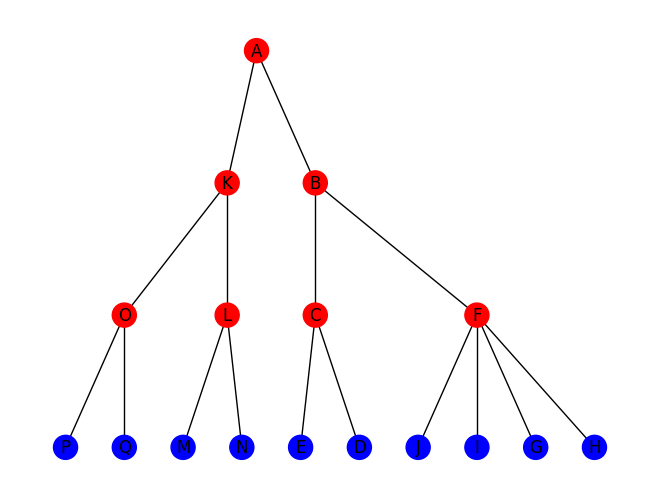

In [ ]:
draw_rooted_tree(T_3, color_dict, root='A')

In [ ]:
def dictionary_to_newick(tree_dict, root):
    def newick_recursive(node):
        if not tree_dict[node]:
            return node
        children_newick = ",".join(newick_recursive(child) for child in tree_dict[node])
        return f"({children_newick}){node}"

    return f"{newick_recursive(root)};"


In [ ]:
root_node = 'A'

newick_tree = dictionary_to_newick(T_3, root_node)
print(newick_tree)

(((J,I,G,H)F,(E,D)C)B,((P,Q)O,(M,N)L)K)A;


# Tree reconstruction (Computational Stemmatology)

In this section, we implement algorithms for tree reconstruction. First, we compute the distance matrix to apply UPGMA and Neighbor Joining.  




In [ ]:
S = list(S)

M = np.zeros((len(S),len(S)))

for i in range(len(S)):
    for j in range(len(S)):
        M[i,j] = Levenshtein.distance(texts[S[i]], texts[S[j]])
        #M[i,j] = 1 - sim(texts[S[i]],texts[S[j]])

In [ ]:
M

array([[  0., 212., 305., 401., 388., 385., 382., 259., 323., 184.],
       [212.,   0., 211., 424., 419., 373., 421., 288., 287., 209.],
       [305., 211.,   0., 475., 440., 404., 442., 307., 268., 268.],
       [401., 424., 475.,   0., 261., 291., 164., 377., 400., 404.],
       [388., 419., 440., 261.,   0., 167., 287., 377., 398., 395.],
       [385., 373., 404., 291., 167.,   0., 282., 372., 394., 377.],
       [382., 421., 442., 164., 287., 282.,   0., 385., 387., 401.],
       [259., 288., 307., 377., 377., 372., 385.,   0., 219., 282.],
       [323., 287., 268., 400., 398., 394., 387., 219.,   0., 309.],
       [184., 209., 268., 404., 395., 377., 401., 282., 309.,   0.]])

Depiction of the distance matrix.

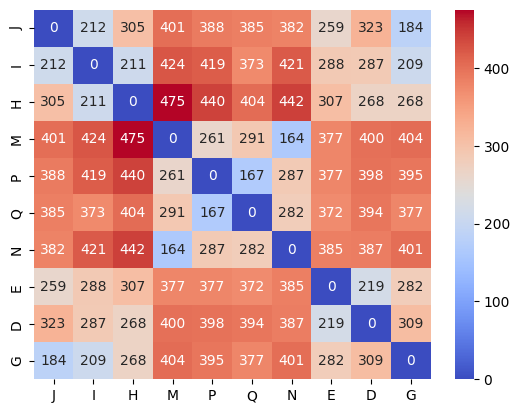

In [ ]:
sn.heatmap(M, cmap='coolwarm', annot=True, fmt=".0f",xticklabels=S,yticklabels=S)
#plt.title('Levenshtein Distance Matrix (Blue Nodes)')
#plt.xlabel('Node Index')
#plt.ylabel('Node Index')
plt.savefig("cm_1.png")
plt.show()


**Alignment**

In [ ]:
sequences = [texts[s] for s in list(S)]
alignment = collateX(sequences)

In [ ]:
collation = Collation()
for s in list(S):
    collation.add_plain_witness(s, texts[s])

alignment_table = collate(collation)
print(alignment_table)

+---+------------+-------+--------+--------+------------+-------+-----+------+------+------------+-----+-----+------+-------+--------------+--------------+-----+-----------+-----------+------+------+---+-----+-----------+-----+--------------+-----+--------+---+-----+-------+-------+------------+-------+---------------+-----+---+------+-----+---------+----------+----+-----+--------+-------+-------+---+-----+---------+---+--------+-----+-----+---------+-----+----------+-----+----+--------+-----+------+---+-----+-------+--------+------+------------+-----+--------+----------+---+----------+-----------+------+------+--------+------+-------+-----+-------+-----+-------+-------------+-----+-----------+---------+------+----------+-----+--------+---------+-----+--------+---+------------+------------+-----+--------+--------+-----------+----------+---------+------+--------+----+-----+---+----+-----+---------+-------+----------+---+------+---------+---+-----------+------+-----------+---+-------+---

### Clasical algorithms

UPGMA and NJ are classical algorithms for tree reconstruction, widely applied in bioinformatics. In this case, both methods prove to be highly effective.


In [ ]:
tree  = upgma(np.abs(M))
tree2 = neighbor_joining(np.abs(M))

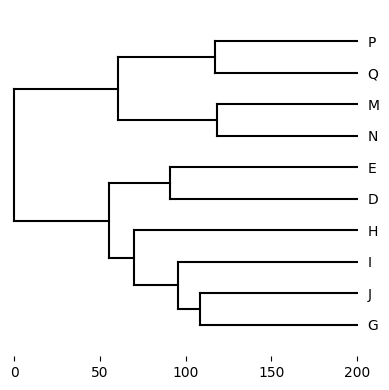

In [ ]:
fig = plt.figure(figsize=(4.0, 4.0))
ax = fig.add_subplot(111)
plot_dendrogram(
    ax, tree, labels=S,
    color="black"
)
fig.tight_layout()
plt.show()

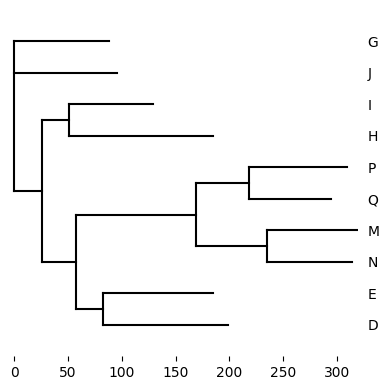

In [ ]:
fig = plt.figure(figsize=(4.0, 4.0))
ax = fig.add_subplot(111)
plot_dendrogram(
    ax, tree2, labels=S,
    color="black"
)
fig.tight_layout()
plt.show()

In [ ]:
newick_tree1 = tree.to_newick(labels=S,include_distance=False)
newick_tree1

'(((((G,J),I),H),(D,E)),((N,M),(Q,P)));'

In [ ]:
newick_tree2 = tree2.to_newick(labels=S,include_distance=False)
newick_tree2

'((((D,E),((N,M),(Q,P))),(H,I)),J,G);'

### Simple Majority Rule

Although it is not a tree reconstruction algorithm but rather a text reconstruction algorithm, we implement it here because it is used in Hoenen's algorithm.  


In [ ]:
def mode_algorithm(alignment_sequence,variation = 1):
    mode = max(set(alignment_sequence), key=alignment_sequence.count)
    if mode == '_':
        set2 = set(alignment_sequence).difference({'_'})
        mode2 = max(set2, key=alignment_sequence.count)
        n1 = alignment_sequence.count('_')
        n2 = alignment_sequence.count(mode2)
        if variation == 2:
            return mode2
        if n1 > n2:
            mode = '_'
        else:
            return mode2
    return mode

def SMR(alignment_sequence,alignment_type = 2,variation=1):
    output_text = ''
    for i in range(len(alignment_sequence)):
        if alignment_type == 1:
            output_text += mode_algorithm(alignment_sequence[i],variation=variation)
        elif alignment_type == 2:
            output_text += mode_algorithm(alignment_sequence[i],variation=variation) + ' '
    if alignment_type == 2:
        output_text = output_text.strip()
    return output_text.replace("_", "")

In [ ]:
alignment = collateX(sequences)
omega_mode = SMR(alignment,variation=2)

In [ ]:
omega_mode

'caption  the repast of hours "** mara sco  red the bite marks crescent on her wrists, throbbing each  a man catcalled her  the subway . by 2023, she’d learn their purpose  . when her boss    branch e   she pressed a scar     shivered . he mislay her name , her face, threat he’d  the  deepened ,  skin like moth   .  who eat *    silence into survival  mara’s mother had  a perversion dissolving its  into     in an    the  tests  ,  gripped a senator’s    ears peeled   childhood, his mother’s stifled rage— until he vomited apologies . the and ravenous .  she  at   veins  in silver . strangers  her: dykes  ,  teen in a *roe * shirt. as mara  ved, the scars  to their wrists,  like shared constellations . time devou but never gested .'

In [ ]:
sim(text0,omega_mode)

0.7498784065246582

In [ ]:
fix_text(omega_mode)

'Caption the repast of hours: "**Mara scored the bite marks crescent on her wrists, throbbing each time a man catcalled her in the subway. By 2023, she’d learn their purpose. When her boss branched out, she pressed a scar and shivered. He mislaid her name, her face, a threat he’d deepened, skin like moth. Who eats silence into survival? Mara’s mother had a perversion dissolving its way into the tests, gripped a senator’s ears peeled back. Childhood, his mother’s stifled rage—until he vomited apologies. The world was ravenous. She looked at veins in silver. Strangers called her: dykes, a teen in a *roe* shirt. As Mara observed, the scars mirrored their wrists, like shared constellations. Time devoured, but never digested."'

In [ ]:
omega_mode = correct_text(omega_mode)
omega_mode

'Caption the repast of hours:\n\nMara scored the bite marks, crescent-shaped on her wrists, throbbing each time a man catcalled her on the subway. By 2023, she would learn their purpose. When her boss branched out, she pressed a scar and shivered. He mislaid her name, her face, a threat that deepened, skin like moth wings. Who eats silence into survival? Mara’s mother had a perversion, dissolving its meaning into chaos. In an office, the tests gripped a senator’s attention; his ears peeled back to childhood, his mother’s stifled rage—until he vomited apologies. The room was ravenous. She traced veins of silver. Strangers surrounded her: dykes, teens in a Roe v. Wade shirt. As Mara moved, the scars spoke to their wrists, like shared constellations. Time devoured, but never digested.'

In [ ]:
sim(text0,omega_mode)

0.7459282875061035

### Hoenen, 2018

Implementation of Hoenen's second algorithm (2018) for tree / text reconstruction.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
vectors = model.encode(sequences)

kmeans = KMeans(n_clusters=3, random_state=42).fit(vectors)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Labels:", labels)
print("Centroids:", centroids)


Labels: [2 1 1 0 0 1 0 2 1 1]
Centroids: [[ 0.06117671  0.02150814  0.18061045 ...  0.00173986 -0.17140599
   0.05099277]
 [ 0.00625365 -0.00991996  0.12349872 ...  0.02464791 -0.17255585
   0.17363046]
 [ 0.05723008  0.12994353  0.04567496 ...  0.00539808 -0.07751108
   0.20381707]]


In [ ]:
class HoenenReconstructor:
    def __init__(self, model_encoder):
        """
        Initialize with the model used for encoding text sequences

        Parameters:
        -----------
        model_encoder : object
            An encoder model with an encode method that transforms text to vectors
        """
        self.model = model_encoder

    def cluster_sequences(self, sequences, n_clusters=3):
        """
        Cluster the sequences using K-means

        Parameters:
        -----------
        sequences : list of str
            The text sequences to cluster
        n_clusters : int
            Number of clusters to create

        Returns:
        --------
        tuple
            (labels, centroids) where labels are the cluster assignments and
            centroids are the cluster centers
        """
        vectors = self.model.encode(sequences)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(vectors)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        return labels, centroids

    def create_hyperarchetype(self, sequences):
        """
        Create a hyperarchetype from sequences using collateX and SMR

        Parameters:
        -----------
        sequences : list of str
            The text sequences to align and combine

        Returns:
        --------
        str
            The reconstructed text (hyperarchetype)
        """
        alignment = collateX(sequences)
        omega_mode = SMR(alignment)
        return omega_mode

    def reconstruct_recursive(self, sequences, node_names, depth=0, max_depth=10):
        """
        Recursively reconstruct text using the Hoenen algorithm

        Parameters:
        -----------
        sequences : list of str
            The text sequences to reconstruct from
        node_names : list of str
            Names of the nodes corresponding to sequences
        depth : int
            Current recursion depth
        max_depth : int
            Maximum recursion depth to prevent infinite recursion

        Returns:
        --------
        tuple
            (reconstructed_text, clusters, cluster_names, tree_structure)
        """
        if depth >= max_depth:
            return self.create_hyperarchetype(sequences), [], [], "(" + ",".join(node_names) + ")"

        # Base case: if only one sequence or very few sequences
        if len(sequences) <= 2:
            return self.create_hyperarchetype(sequences), [], [], "(" + ",".join(node_names) + ")"

        # Determine appropriate number of clusters based on sequence count
        n_clusters = min(3, len(sequences) - 1)

        # Cluster the sequences
        labels, _ = self.cluster_sequences(sequences, n_clusters)

        # Group sequences and their names by cluster
        clusters = [[] for _ in range(n_clusters)]
        cluster_names = [[] for _ in range(n_clusters)]

        for i, label in enumerate(labels):
            clusters[label].append(sequences[i])
            cluster_names[label].append(node_names[i])

        # Filter out empty clusters
        non_empty_indices = [i for i, cluster in enumerate(clusters) if cluster]
        clusters = [clusters[i] for i in non_empty_indices]
        cluster_names = [cluster_names[i] for i in non_empty_indices]

        # If clustering failed to separate sequences
        if len(clusters) <= 1:
            return self.create_hyperarchetype(sequences), clusters, cluster_names, "(" + ",".join(node_names) + ")"

        # Recursively process each cluster
        cluster_results = []
        subtrees = []

        for i, (cluster, names) in enumerate(zip(clusters, cluster_names)):
            reconstructed, sub_clusters, sub_names, subtree = self.reconstruct_recursive(
                cluster, names, depth + 1, max_depth
            )
            cluster_results.append(reconstructed)
            subtrees.append(subtree)

        # Create a new set of sequences from the cluster results
        new_sequences = cluster_results

        # Create newick tree representation
        tree = "(" + ",".join(subtrees) + ")"

        # Final step: create hyperarchetype from the new set of sequences
        final_text = self.create_hyperarchetype(new_sequences)

        return final_text, clusters, cluster_names, tree

    def reconstruct(self, sequences, node_names=None, max_depth=10):
        """
        Main method to reconstruct text using the Hoenen algorithm

        Parameters:
        -----------
        sequences : list of str
            The text sequences to reconstruct from
        node_names : list of str, optional
            Names of the nodes corresponding to sequences
        max_depth : int
            Maximum recursion depth

        Returns:
        --------
        dict
            Contains reconstructed text and the phylogenetic tree in Newick format
        """
        # If node names aren't provided, use default numbered names
        if node_names is None:
            node_names = [f"S{i}" for i in range(len(sequences))]

        # Validate input
        if len(node_names) != len(sequences):
            raise ValueError("The number of node names must match the number of sequences")

        reconstructed_text, _, _, newick_tree = self.reconstruct_recursive(
            sequences, node_names, max_depth=max_depth
        )

        # Ensure the Newick tree is properly formatted with a root
        if not newick_tree.endswith(";"):
            newick_tree += ";"

        return {
            "reconstructed_text": reconstructed_text,
            "phylogenetic_tree": newick_tree
        }


# Usage example
def hoenen_algorithm(sequences, encoder_model = model, node_names=None):
    """
    Demonstrate the Hoenen algorithm

    Parameters:
    -----------
    sequences : list of str
        The text sequences to reconstruct from
    encoder_model : object
        The encoder model with an encode method

    Returns:
    --------
    dict
        Results of the reconstruction
    """
    reconstructor = HoenenReconstructor(encoder_model)
    result = reconstructor.reconstruct(sequences, node_names=node_names)

    # Add tree visualization
    # tree_viz = reconstructor.visualize_tree(result["phylogenetic_tree"])
    # result["tree_visualization"] = tree_viz

    return result["reconstructed_text"], result["phylogenetic_tree"]

In [ ]:
omega_hoenen,tree_h = hoenen_algorithm(sequences,node_names=S)

In [ ]:
tree_h

'(((P),(M,N)),(((Q),(H,G)),(D),(I)),(J,E));'

In [ ]:
omega_hoenen

'caption " the  of  sco red the bite marks crescent  her wrists, throbbing each time a  cat led her on the subway . by 2023,  their  when  boss  she pressed a  shivered . he mislay  her name ,    deepened , she pressed a  shivered . moth  who eat *  into survi mara’s mother had  a perversion its  into  back—his    ,  ’s hand  childhood, his  stifled rage— until he vomited apologies . the  and  . she  at  veins  in  . strangers  dykes  ,  teen a *roe*  mara  ved, the scars to their wrists,  like shared constellations . time devou but gested .'

In [ ]:
sim(text0,omega_hoenen)

0.7086682319641113

In [ ]:
fix_text(omega_hoenen)

'Caption: "The scars of the bite marks crescent on her wrists throbbed each time a cat led her on the subway. By 2023, their boss mislaid her name. She pressed a shivered hand, and as her rage deepened, she pressed a shivered moth who ate into survival. Mara’s mother had a perversion that traced back to his childhood, his stifled rage—until he vomited apologies. The strangers and dykes, a teen named Mara, bore the scars on their wrists like shared constellations. Time devoured but gestured."'

In [ ]:
omega_hoenen = correct_text(omega_hoenen)
omega_hoenen

'Caption: "The scars of the bite marks crescent on her wrists throbbed each time a cat led her on the subway. By 2023, their memories faded when her boss pressed a button, and she shivered. He mislaid her name, which deepened her discomfort as she pressed a finger to her wrist and shivered again. Moths who eat away at the fabric of survival, Mara’s mother had a perversion that traced back—his father’s hand, childhood memories, his stifled rage—until he vomited apologies. The pain lingered and festered. She looked at the veins in her wrists. Strangers and dykes, a teenage Mara recalled, the scars on their wrists like shared constellations. Time devoured but suggested."'

In [ ]:
sim(text0,omega_hoenen)

0.8258609771728516

**Note:** This notebook includes only the basic code implementations necessary for demonstrating the core functionality of the algorithms. The heavy comparison routines, which require extensive manual intervention and long execution times, have been omitted for clarity and efficiency. These additional modules can be easily implemented based on the provided code if needed.


# Text reconstruction

Once the tree has been reconstructed, we can implement the remaining text reconstruction algorithms. Some of these are tree-dependent, meaning they require a reconstructed tree as input. Based on the results of the article, we use NJ and UPGMA with Levenshtein for this purpose.  



## General text reconstruction

### Fitch algorithm

Implementation of the classical Fitch algorithm.

In [ ]:
from collections import defaultdict

In [ ]:
class Node:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parent = None
        self.possible_states = None
        self.final_state = None

    def add_child(self, child):
        self.children.append(child)
        child.parent = self

    def __str__(self):
        return self.name

def parse_newick(newick_str):
    """Parse a Newick string into a tree structure."""
    # Remove the trailing semicolon and any whitespace
    newick_str = newick_str.strip()
    if newick_str.endswith(';'):
        newick_str = newick_str[:-1]

    def parse_node(s, start, end):
        """Recursively parse nodes in the Newick string."""
        if start >= end:
            return None, start

        # Track index and keep track of parentheses
        i = start
        if s[i] == '(':  # Internal node
            i += 1
            node = Node("")  # Unnamed internal node for now

            # Parse children
            while i < end:
                if s[i] == '(':  # Start of a child subtree
                    child, i = parse_node(s, i, end)
                    node.add_child(child)
                elif s[i] == ',':  # Separator between children
                    i += 1
                elif s[i] == ')':  # End of this internal node
                    i += 1
                    break
                else:  # Leaf node
                    leaf_start = i
                    while i < end and s[i] not in ['(', ')', ',']:
                        i += 1
                    leaf_name = s[leaf_start:i].strip()
                    child = Node(leaf_name)
                    node.add_child(child)

            # Check for optional name after closing parenthesis
            name_start = i
            while i < end and s[i] not in ['(', ')', ',', ';']:
                i += 1
            if name_start < i:
                node.name = s[name_start:i].strip()

            return node, i
        else:  # Leaf node
            leaf_start = i
            while i < end and s[i] not in ['(', ')', ',', ';']:
                i += 1
            leaf_name = s[leaf_start:i].strip()
            return Node(leaf_name), i

    root, _ = parse_node(newick_str, 0, len(newick_str))
    return root

def map_leaf_states(root, leaf_names, alignment):
    """Map character states from the alignment to the leaf nodes."""
    leaf_to_node = {}

    def collect_leaves(node):
        if not node.children:  # Leaf node
            leaf_to_node[node.name] = node
        else:
            for child in node.children:
                collect_leaves(child)

    collect_leaves(root)

    # Map each leaf to its corresponding alignment row
    for i, leaf_name in enumerate(leaf_names):
        if leaf_name in leaf_to_node:
            node = leaf_to_node[leaf_name]
            node.possible_states = []
            for pos in range(len(alignment)):
                node.possible_states.append({alignment[pos][i]})

def bottom_up_phase(node):
    """Perform the bottom-up phase of the Fitch algorithm."""
    if not node.possible_states:  # Internal node
        node.possible_states = []

        # Process all children first
        for child in node.children:
            bottom_up_phase(child)

        # For each position in the sequence
        for pos in range(len(node.children[0].possible_states)):
            # Get sets of possible states from all children at this position
            children_states = [child.possible_states[pos] for child in node.children]

            # Intersection of all children's states
            intersection = set.intersection(*children_states)

            if intersection:  # If intersection is not empty
                node.possible_states.append(intersection)
            else:  # If intersection is empty, take the union
                node.possible_states.append(set.union(*children_states))

def top_down_phase(node, sequence_length):
    """Perform the top-down phase of the Fitch algorithm."""
    if node.final_state is None:
        node.final_state = [''] * sequence_length

    # Root node's final state is chosen from its possible states
    if node.parent is None:
        for pos in range(sequence_length):
            # Choose arbitrarily from possible states
            node.final_state[pos] = next(iter(node.possible_states[pos]))

    # For each child, determine its final state
    for child in node.children:
        if child.final_state is None:
            child.final_state = [''] * sequence_length

        for pos in range(sequence_length):
            # If parent's state is in child's possible states, choose it
            if node.final_state[pos] in child.possible_states[pos]:
                child.final_state[pos] = node.final_state[pos]
            else:
                # Otherwise, choose arbitrarily from child's possible states
                child.final_state[pos] = next(iter(child.possible_states[pos]))

        # Recursively process this child's children
        top_down_phase(child, sequence_length)

def run_fitch_algorithm(newick_str, leaf_names, alignment):
    """Run the Fitch algorithm to reconstruct ancestral sequences."""
    # Parse the Newick string to get the tree
    root = parse_newick(newick_str)

    # Map the alignment to the leaf nodes
    map_leaf_states(root, leaf_names, alignment)

    # Perform the bottom-up phase
    bottom_up_phase(root)

    # Perform the top-down phase
    sequence_length = len(alignment)
    top_down_phase(root, sequence_length)

    # Return the reconstructed sequences for all nodes
    results = {}

    def collect_sequences(node):
        if node.final_state:
            results[node.name or f"Node_{id(node)}"] = ''.join(node.final_state)
        for child in node.children:
            collect_sequences(child)

    collect_sequences(root)
    return results

def print_tree_with_sequences(root):
    """Print the tree with the reconstructed sequences."""
    def print_node(node, prefix="", is_last=True):
        # Print the node with its sequence
        sequence = ''.join(node.final_state) if node.final_state else ""
        name = node.name or f"Internal_{id(node)}"
        print(f"{prefix}{'└── ' if is_last else '├── '}{name}: {sequence}")

        # Print children
        for i, child in enumerate(node.children):
            is_child_last = (i == len(node.children) - 1)
            print_node(child, prefix + ("    " if is_last else "│   "), is_child_last)

    print_node(root)


In [ ]:
# Example usage
def main():
    newick_str = "((A,B),C);"
    leaf_names = ['A', 'B', 'C']
    alignmentx = [
        ['x', 'r', 'x'],
        ['x', 'x', 'x'],
        ['x', 'x', 'x']
    ]

    root = parse_newick(newick_str)
    map_leaf_states(root, leaf_names, alignmentx)
    bottom_up_phase(root)

    sequence_length = len(alignmentx)
    top_down_phase(root, sequence_length)

    print("Reconstructed sequences:")
    print_tree_with_sequences(root)

    results = run_fitch_algorithm(newick_str, leaf_names, alignmentx)
    print("\nResults as dictionary:")
    for node_name, sequence in results.items():
        print(f"{node_name}: {sequence}")

if __name__ == "__main__":
    main()

Reconstructed sequences:
└── Internal_139997242158096: xxx
    ├── Internal_139997251663824: xxx
    │   ├── A: xxx
    │   └── B: rxx
    └── C: xxx

Results as dictionary:
Node_139997187623312: xxx
Node_139997187629136: xxx
A: xxx
B: rxx
C: xxx


In [ ]:
def fitch(newick_str, leaf_names, alignment):
    """
    Run the Fitch algorithm and return only the reconstructed text.

    Args:
        newick_str (str): Newick format string representing the tree
        leaf_names (list): List of leaf names in the order they appear in the alignment
        alignment (list): List of lists representing character states at each position

    Returns:
        str: The reconstructed ancestral sequence at the root of the tree
    """
    # Parse the tree
    root = parse_newick(newick_str)

    # Map states to leaves
    map_leaf_states(root, leaf_names, alignment)

    # Run bottom-up phase
    bottom_up_phase(root)

    # Run top-down phase
    sequence_length = len(alignment)
    top_down_phase(root, sequence_length)

    # Return root sequence
    root_sequence = ' '.join(root.final_state) if root.final_state else ""
    return root_sequence

In [ ]:
omega_fitch = fitch(newick_tree2, S, alignment)
omega_fitch

'  the  of Hours "**  sco  red the bite marks crescent on her wrists, throbbing  time a  catcalled   the subway . via 2023, she’d learn  purpose  . when her   in  branch  vator , she pressed a      shivered . he  her  , her face, threat he’d  the      like moth     who eat *     into survi  mara’s mother    sack  its       in an    the  tests  , mara  a senator’s    ears    childhood, his mother’s  rage— until he vomited the moreover   and ravenous .  she     veins mapped in argent . gers        in a *roe *  as mara dis ved,  jump  to their wrists,  like sha constellations . time devou  never digested .'

In [ ]:
sim(text0,omega_fitch)

0.6834800243377686

In [ ]:
fix_text(omega_fitch)

'The Hours "** sco red the bite marks crescent on her wrists, throbbing time a catcalled the subway. Via 2023, she’d learn purpose. When her in branch vator, she pressed a shivered. He her, her face, threat he’d the like moth who eat into survi mara’s mother sack its in an the tests, mara a senator’s ears childhood, his mother’s rage—until he vomited the moreover and ravenous. She veins mapped in argent. Gers in a roe as mara dis ved, jump to their wrists, like sha constellations. Time devou never digested.'

In [ ]:
omega_fitch = correct_text(omega_fitch)
omega_fitch

'The Hours "**" scored the bite marks crescent on her wrists, throbbing over time as a catcalled voice echoed in the subway. By 2023, she would learn her purpose. When she entered the elevator, she pressed a button and shivered. He challenged her, his gaze assessing her face, a threat he’d concealed like moths that eat through the fabric of survival. Mara’s mother had packed a sack with its contents for a journey through the tests. Mara recalled a senator’s ears in childhood, his mother’s rage—until he vomited the dark and ravenous truths. She felt her veins mapped in argent hues. The glares in a roe as Mara discovered, jumped to their wrists like sharp constellations. Time devoured the moments, which were never fully digested.'

In [ ]:
fix_text(omega_fitch)

'The Hours "**" scored the bite marks crescent on her wrists, throbbing over time as a catcalled voice echoed in the subway. By 2023, she would learn her purpose. When she entered the elevator, she pressed a button and shivered. He challenged her, his gaze assessing her face, a threat he’d concealed like moths that eat through the fabric of survival. Mara’s mother had packed a sack with its contents for a journey through the tests. Mara recalled a senator’s ears in childhood, his mother’s rage—until he vomited the dark and ravenous truths. She felt her veins mapped in argent hues. The glares in a roe as Mara discovered jumped to their wrists like sharp constellations. Time devoured the moments, which were never fully digested.'

In [ ]:
def reduce_spaces(text):
    """Reduces multiple spaces in a string to single spaces.

    Args:
      text: The input string.

    Returns:
      The string with multiple spaces reduced to single spaces.
    """
    text = text.replace("_","")
    return re.sub(r'\s+', ' ', text)


### RHM Algorithm

Implementation of the RHM algorithm.

In [ ]:
import gzip
from io import BytesIO
from collections import defaultdict

In [ ]:
class TreeNode:
    def __init__(self, name=""):
        self.name = name
        self.children = []
        self.is_leaf = False

    def add_child(self, child):
        self.children.append(child)

    def __str__(self):
        if self.is_leaf:
            return self.name
        else:
            return f"({','.join(str(child) for child in self.children)}){self.name}"

def parse_newick(newick_str):
    """Parse a Newick tree string into a tree structure."""
    # Remove whitespace and the ending semicolon
    newick_str = newick_str.strip()
    if newick_str.endswith(';'):
        newick_str = newick_str[:-1]

    # Recursive function to parse the Newick string
    def parse_subtree(s, i=0):
        node = TreeNode()

        # Check if we're starting with a parenthesis (internal node)
        if i < len(s) and s[i] == '(':
            i += 1  # Skip the opening parenthesis

            # Parse children until we find the closing parenthesis
            while i < len(s) and s[i] != ')':
                child, i = parse_subtree(s, i)
                node.add_child(child)

                # Skip the comma if present
                if i < len(s) and s[i] == ',':
                    i += 1

            # Skip the closing parenthesis
            if i < len(s) and s[i] == ')':
                i += 1

            # Extract name after the closing parenthesis if any
            name_start = i
            while i < len(s) and s[i] not in [',', ')', ';']:
                i += 1

            if name_start < i:
                node.name = s[name_start:i]
        else:
            # Leaf node
            name_end = min((s.find(',', i) if s.find(',', i) != -1 else len(s)),
                          (s.find(')', i) if s.find(')', i) != -1 else len(s)))
            node.name = s[i:name_end]
            node.is_leaf = True
            i = name_end

        return node, i

    # Parse the tree starting from the beginning
    tree, _ = parse_subtree(newick_str)
    return tree

def compute_compression_distance_conditional(x, y):
    """
    Compute the compression distance C(y|x) = len(compress(x+y)) - len(compress(x))
    where x and y are strings.

    This is the implementation provided by the user, using gzip compression.
    """
    # Convert sequences to strings if they're arrays
    if isinstance(x, list):
        x = ''.join(x)
    if isinstance(y, list):
        y = ''.join(y)

    # Convert strings to bytes for gzip
    x_bytes = x.encode('utf-8')
    y_bytes = y.encode('utf-8')

    # Compress x
    x_compressed = BytesIO()
    with gzip.GzipFile(fileobj=x_compressed, mode='wb') as f:
        f.write(x_bytes)
    x_size = len(x_compressed.getvalue())

    # Compress x+y
    xy_compressed = BytesIO()
    with gzip.GzipFile(fileobj=xy_compressed, mode='wb') as f:
        f.write(x_bytes + y_bytes)
    xy_size = len(xy_compressed.getvalue())

    # Return the conditional compression distance
    return xy_size - x_size

def compute_compression_distance_ncd(x, y):
    """
    Compute the Normalized Compression Distance (NCD) as defined in the literature:
    NCD(x,y) = (C(xy) - min(C(x),C(y))) / max(C(x),C(y))
    where C(x) is the compressed size of x.

    This is a symmetric measure (NCD(x,y) = NCD(y,x)).
    """
    # Convert sequences to strings if they're arrays
    if isinstance(x, list):
        x = ''.join(x)
    if isinstance(y, list):
        y = ''.join(y)

    # Convert strings to bytes for gzip
    x_bytes = x.encode('utf-8')
    y_bytes = y.encode('utf-8')

    # Compress x
    x_compressed = BytesIO()
    with gzip.GzipFile(fileobj=x_compressed, mode='wb') as f:
        f.write(x_bytes)
    x_size = len(x_compressed.getvalue())

    # Compress y
    y_compressed = BytesIO()
    with gzip.GzipFile(fileobj=y_compressed, mode='wb') as f:
        f.write(y_bytes)
    y_size = len(y_compressed.getvalue())

    # Compress xy
    xy_compressed = BytesIO()
    with gzip.GzipFile(fileobj=xy_compressed, mode='wb') as f:
        f.write(x_bytes + y_bytes)
    xy_size = len(xy_compressed.getvalue())

    # Calculate NCD
    numerator = xy_size - min(x_size, y_size)
    denominator = max(x_size, y_size)

    # Avoid division by zero
    if denominator == 0:
        return 0

    return numerator / denominator

def compute_levenshtein_distance(s1, s2):
    """Compute the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return compute_levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def compute_substitution_cost(variant1, variant2, method="levenshtein"):
    """
    Compute the substitution cost between two variants.

    Args:
        variant1: First variant text
        variant2: Second variant text
        method: The method to use for computing distance
                - "levenshtein": normalized Levenshtein distance
                - "compression_conditional": conditional compression distance
                - "compression_ncd": normalized compression distance

    Returns:
        A distance value between 0 and 1
    """
    if method == "levenshtein":
        # Normalize by the maximum length to get a value between 0 and 1
        max_len = max(len(variant1), len(variant2))
        if max_len == 0:
            return 0
        return compute_levenshtein_distance(variant1, variant2) / max_len

    elif method == "compression_conditional":
        # Use conditional compression distance
        # Normalize to be between 0 and 1
        cond_dist = compute_compression_distance_conditional(variant1, variant2)
        # Simple normalization by the length of the second string
        # Could be improved with more sophisticated normalization
        if len(variant2) == 0:
            return 0
        return cond_dist / (len(variant2.encode('utf-8')) + 1)  # +1 to avoid division by zero

    elif method == "compression_ncd":
        # Use normalized compression distance (already normalized)
        return compute_compression_distance_ncd(variant1, variant2)

    else:
        raise ValueError(f"Unknown distance method: {method}")

def compute_roos_costs(tree, text_variants, cost_method="levenshtein"):
    """
    Compute the Roos algorithm costs for each variant at each node.

    Args:
        tree: The root node of the parsed tree
        text_variants: Dictionary mapping variant names to their text content
        cost_method: Method to use for computing substitution costs
                    - "levenshtein": normalized Levenshtein distance
                    - "compression_conditional": conditional compression distance
                    - "compression_ncd": normalized compression distance

    Returns:
        Dictionary mapping node names to their cost tables
    """
    # Convert variant names to indices for easier handling
    variant_names = sorted(text_variants.keys())
    variant_indices = {name: i for i, name in enumerate(variant_names)}
    num_variants = len(variant_names)

    # Precompute substitution costs
    substitution_costs = {}
    for v1 in variant_names:
        for v2 in variant_names:
            substitution_costs[(v1, v2)] = compute_substitution_cost(
                text_variants[v1], text_variants[v2], method=cost_method
            )

    # Dictionary to store costs for each node
    node_costs = {}

    def compute_costs_recursive(node, node_id="root"):
        if node.is_leaf:
            # For leaf nodes, the cost is 0 for its own variant, infinity for others
            costs = [float('inf')] * num_variants
            if node.name in variant_indices:
                costs[variant_indices[node.name]] = 0
            node_costs[node.name] = costs
            return costs

        # For internal nodes with children
        if len(node.children) == 2:
            left_child, right_child = node.children
            left_costs = compute_costs_recursive(left_child, f"{node_id}_left")
            right_costs = compute_costs_recursive(right_child, f"{node_id}_right")

            # Compute costs for this node
            node_cost_table = [0] * num_variants
            for j, variant_j in enumerate(variant_names):
                # Find min_k [C'(x^k | x^j) + cost_left(k)]
                min_left_cost = float('inf')
                for k, variant_k in enumerate(variant_names):
                    cost = substitution_costs[(variant_k, variant_j)] + left_costs[k]
                    min_left_cost = min(min_left_cost, cost)

                # Find min_l [C'(x^l | x^j) + cost_right(l)]
                min_right_cost = float('inf')
                for l, variant_l in enumerate(variant_names):
                    cost = substitution_costs[(variant_l, variant_j)] + right_costs[l]
                    min_right_cost = min(min_right_cost, cost)

                # Total cost for variant j at this node
                node_cost_table[j] = min_left_cost + min_right_cost

            node_costs[node.name or node_id] = node_cost_table
            return node_cost_table
        else:
            # Handle nodes with != 2 children
            raise ValueError(f"Roos algorithm requires binary trees (nodes with exactly 2 children). Node {node_id} has {len(node.children)} children.")

    # Start the recursive computation from the root
    root_costs = compute_costs_recursive(tree)

    # Compute total costs including the final substitution cost
    total_costs = {}
    for j, variant_j in enumerate(variant_names):
        # Total cost is cost_root(j) + C'(x^j)
        # For simplicity, we're using 0 as the additional cost
        total_costs[variant_j] = root_costs[j]

    return node_costs, total_costs, substitution_costs

def find_best_variant(total_costs):
    """Find the variant with the minimum total cost."""
    min_cost = float('inf')
    best_variant = None

    for variant, cost in total_costs.items():
        if cost < min_cost:
            min_cost = cost
            best_variant = variant

    return best_variant, min_cost

def roos_algorithm(newick_str, text_variants, cost_method="levenshtein"):
    """
    Main function to run the Roos algorithm.

    Args:
        newick_str: Newick string representation of the tree
        text_variants: Dictionary mapping variant names to their text content
        cost_method: Method to use for computing costs
                    - "levenshtein": normalized Levenshtein distance
                    - "compression_conditional": conditional compression distance
                    - "compression_ncd": normalized compression distance

    Returns:
        The best variant and its cost
    """
    tree = parse_newick(newick_str)
    # print(f"Parsed tree: {tree}")

    # Verify the tree is binary
    def verify_binary(node):
        if not node.is_leaf and len(node.children) != 2:
            raise ValueError(f"Node {node.name or 'unnamed'} has {len(node.children)} children, expected 2")
        for child in node.children:
            verify_binary(child)

    verify_binary(tree)

    node_costs, total_costs, substitution_costs = compute_roos_costs(tree, text_variants, cost_method)
    best_variant, min_cost = find_best_variant(total_costs)

    return best_variant, min_cost, node_costs, total_costs, substitution_costs

In [ ]:
def roos0(newick_tree, texts,cost_method="compression_conditional"):
    """
    Use for no-aligment. Highly dependend on the sent_tokenizer
    """
    output = ''
    texts2 = dict()
    for s in texts.keys():
        texts2[s] = sent_tokenize(texts[s])

    s = random.choice(list(texts2.keys()))

    for i in range(len(texts2[s])):
        texts_i = dict()
        for s in texts.keys():
            print(s,i,texts2[s])
            texts_i[s] = texts2[s][i]
        best_variant, _, _, _, _= roos_algorithm(
            newick_tree, texts_i, cost_method=cost_method
        )
        output += texts_i[best_variant]
    return output

In [ ]:
alignment[0]

['you', 'you', 'you', 'you', 'you', 'y', 'you', 'you']

In [ ]:
def roos(newick_tree, alignment,S, cost_method="compression_conditional"):
    """
    Use with CollateX aligment.
    """
    output = ''

    for i in range(len(alignment)):
        alignment_i = dict(zip(S, alignment[i]))
        best_variant, _, _, _, _= roos_algorithm(
            newick_tree, alignment_i, cost_method=cost_method
        )
        #print(best_variant)
        output += alignment_i[best_variant] + " "
    return output.replace("  "," ")

In [ ]:
omega_roos = roos(newick_tree1, alignment,S, cost_method="levenshtein")
omega_roos

'privilege " the repast of hours "** mara sco red the bite marks crescent on her wrists, throbbing each time a man catcalled her the subway . by 2023, she’d learned their pur  when her   branch e  she pressed a scar   shivered . he mislay her  her face, threat he’d hissed—but the  , nagging skin like moth  . had who eat * silen  silence into survival . mara’s mother a a perversion its memory into   in an   capitol  ,  senator’s  years peeled back— childhood, his mother’s stifled rage— until he vomited apologies . the and ravenous . she collapsed at  veins in silver . strangers her: dykes , teen in a *roe * shirt. as mara dis ved, the scars to their wrists, ke like shared constellations . time devou ver gested . '

In [ ]:
sim(text0,omega_roos)

0.7703017592430115

In [ ]:
fix_text(omega_roos)

'privilege "the repast of hours." Mara scored the bite marks crescent on her wrists, throbbing each time a man catcalled her in the subway. By 2023, she’d learned their purpose. When her branch pressed a scar, she shivered. He mislaid her face, threat he’d hissed—but the nagging skin felt like moths. Had she who ate silence into survival? Mara’s mother, a perversion of its memory, turned it into an insidious capitol. The senator’s years peeled back—childhood, his mother’s stifled rage—until he vomited apologies. The past was ravenous. She collapsed at veins in silver. Strangers surrounded her: dykes, teens in a Roe shirt. As Mara dissolved, the scars on their wrists looked like shared constellations. Time devoured her suggestion.'

In [ ]:
omega_roos_c = correct_text(omega_roos)
omega_roos_c

'Privilege "the repast of hours." Mara scored the bite marks, crescent-shaped on her wrists, throbbing each time a man catcalled her in the subway. By 2023, she’d learned their purpose when her branch broke; she pressed a scar and shivered. He mislaid her gaze, threatened—he’d hissed—but the nagging skin felt like moth wings. Who could silence silence into survival? \n\nMara’s mother had turned a perversion into memory in a crumbling Capitol. The senator’s years peeled back—childhood, his mother’s stifled rage—until he vomited apologies. The wounds remained, ravenous. She collapsed at the sight of silver veins in strangers: dykes, teens in a “Roe” shirt. As Mara observed, the scars on their wrists looked like shared constellations. Time devoured what it had suggested.'

In [ ]:
sim(text0,omega_roos_c)

0.7552587985992432

### UR algorithm

Implementation of the UR algorithm and the variant UR-Bédier.

In [ ]:
from collections import Counter

In [ ]:
def ur_algorithm(alignment, max_iterations=100, convergence_threshold=1e-6):
    """
    Implements the UR algorithm from Koppel, Michaely, and Tal (2016) for stemmatology.

    Parameters:
    alignment (list of lists): Each list represents a document, each element is a token/character
    max_iterations (int): Maximum number of iterations
    convergence_threshold (float): Threshold for convergence

    Returns:
    tuple: (reconstructed_text, document_confidence_scores, token_probabilities)
    """
    # Convert alignment to numpy array for easier manipulation
    alignment = np.array(alignment)

    # m is the number of documents, n is the number of tokens/positions
    m, n = alignment.shape

    # Initialize document confidence scores (p_i)
    p_i = np.ones(m) / m

    # Initialize token probabilities
    token_probs = []  # Will store p(t_j = w) for each position j

    # For each position, determine the unique tokens and initialize probabilities
    for j in range(n):
        unique_tokens = set(alignment[:, j])
        k_j = len(unique_tokens)
        # Initialize with uniform distribution
        token_prob = {token: 1.0 / k_j for token in unique_tokens}
        token_probs.append(token_prob)

    # Main EM loop
    for iteration in range(max_iterations):
        old_p_i = p_i.copy()

        # Step 1: Update token probabilities using current document confidence scores
        for j in range(n):
            position_tokens = alignment[:, j]
            unique_tokens = set(position_tokens)

            for w in unique_tokens:
                # Calculate p(a_j | t_j = w)
                prob = 1.0
                for i in range(m):
                    if alignment[i, j] == w:
                        prob *= p_i[i]
                    else:
                        k_j = len(unique_tokens) - 1  # number of options other than w
                        if k_j > 0:  # avoid division by zero
                            prob *= (1 - p_i[i]) / k_j
                        else:
                            prob *= (1 - p_i[i])  # if k_j = 0, just use (1-p_i)

                token_probs[j][w] = prob

            # Normalize probabilities for position j
            Z = sum(token_probs[j].values())
            if Z > 0:  # avoid division by zero
                for w in token_probs[j]:
                    token_probs[j][w] /= Z

        # Step 2: Update document confidence scores using current token probabilities
        for i in range(m):
            # Calculate p_i = (1/n) * sum_j p(t_j = a_{ij} | a)
            confidence_sum = 0.0
            for j in range(n):
                token = alignment[i, j]
                if token in token_probs[j]:
                    confidence_sum += token_probs[j][token]

            p_i[i] = confidence_sum / n

        # Check for convergence
        if np.max(np.abs(p_i - old_p_i)) < convergence_threshold:
            break

    # Reconstruct text by taking the highest probability token at each position
    reconstructed_text = []
    for j in range(n):
        best_token = max(token_probs[j].items(), key=lambda x: x[1])[0]
        reconstructed_text.append(best_token)

    return reconstructed_text, p_i, token_probs

def format_token_probs(token_probs):
    """Format token probabilities for better readability."""
    formatted = []
    for j, probs in enumerate(token_probs):
        formatted.append(f"Position {j}: " + ", ".join([f"{t}:{p:.4f}" for t, p in probs.items()]))
    return formatted

In [ ]:
# Example usage with the provided alignment
alignment0 = [
    ['d', 'i', 'n', 'o', 's', 'a', 'u', 'r'],
    ['d', 'j', 'n', 'o', 's', 'a', 'i', 'i'],
    ['d', 'i', 'n', 'o', 'g', 'a', 'u', 'r']
]

reconstructed_text, document_confidence, token_probabilities = ur_algorithm(alignment0)

print("Reconstructed text:", "".join(reconstructed_text))
print("\nDocument confidence scores:")
for i, conf in enumerate(document_confidence):
    print(f"Document {i+1}: {conf:.4f}")

print("\nToken probabilities at each position:")
for j, probs in enumerate(format_token_probs(token_probabilities)):
    print(probs)

Reconstructed text: dinosaur

Document confidence scores:
Document 1: 1.0000
Document 2: 0.6250
Document 3: 0.8750

Token probabilities at each position:
Position 0: d:1.0000
Position 1: i:1.0000, j:0.0000
Position 2: n:1.0000
Position 3: o:1.0000
Position 4: g:0.0000, s:1.0000
Position 5: a:1.0000
Position 6: u:1.0000, i:0.0000
Position 7: i:0.0000, r:1.0000


In [ ]:
def transpose_alignment(alignment):
    """
    Transposes the alignment matrix from document-oriented to position-oriented format.

    Parameters:
    alignment (list of lists): Each list represents a document, each element is a token/character

    Returns:
    list of lists: Transposed alignment where each list represents a position
    """
    # Convert to numpy array for easier transposition
    alignment_array = np.array(alignment)

    # Transpose the array
    transposed = alignment_array.T

    # Convert back to list of lists
    transposed_list = [list(row) for row in transposed]

    return transposed_list

**UR-Bédier algorithm**

In [ ]:
reconstructed_text, document_confidence, _ = ur_algorithm(transpose_alignment(alignment))
omega_dip = ' '.join(reconstructed_text)
omega_dip = omega_dip.replace("_", "")
omega_dip = omega_dip.replace("  "," ")
omega_dip

'caption " the feast of hours "** mara voss discovered the marks greatest cry scars her wrists, throbbing each a man catcalled her the subway . by 2023,  their  when her boss  the branch eleva  she pressed scar to his air shivered . he forgot her name , the threat he’d hissed—but the scar deepened , nagging skin like moth wool . . * wo who eat * genera stitching silence into  mara’s mother had erased a perversion its to  dust in an   can protests , gripped senator’s hand mid-sneer . years peeled back— his childhood, his stifled rage— until he vomited apologies . the scars spread, fractal and she collapsed at the rally, veins in  strangers carried her: dykes , mothers , a teen in a *roe * shirt. mara  the scars to their wrists, blooming like shared constellations . time devoured, but ver gested .'

In [ ]:
sim(text0,omega_dip)

0.8209971189498901

In [ ]:
fix_text(omega_dip)

'Caption: "The Feast of Hours"\n\nMara Voss discovered the marks, greatest cry scars on her wrists, throbbing each time a man catcalled her in the subway. By 2023, when her boss took the branch elevator, she pressed a scar to his air, and he shivered. He forgot her name, the threat he’d hissed—but the scar deepened, nagging skin like moth wool. *Wo who eat* genera stitching silence into Mara’s mother had erased a perversion, its dust in an... can protests, gripping the senator’s hand mid-sneer. Years peeled back—his childhood, his stifled rage—until he vomited apologies. The scars spread, fractal, and she collapsed at the rally; strangers carried her: dykes, mothers, a teen in a *Roe* shirt. Mara showed the scars on their wrists, blooming like shared constellations. Time devoured, but ver gested.'

In [ ]:
omega_dip = correct_text(omega_dip)
omega_dip

'Caption: "The Feast of Hours"\n\nMara Voss discovered the greatest scars on her wrists, throbbing from when a man had catcalled her on the subway. By 2023, when her boss elevated her branch, she pressed the scar to his air, causing it to shiver. He forgot her name and the threat he’d hissed—but the scar deepened, nagging at her skin like moth-eaten wool.\n\n"Who eats?" she wondered, as generations stitched silence into her history. Mara’s mother had erased a perversion, turning it to dust in an attempt to silence protests. She gripped a senator’s hand mid-sneer. Years peeled back—his childhood, his stifled rage—until he vomited apologies. The scars spread, fractal, and she collapsed at the rally. Strangers carried her: dykes, mothers, a teen in a "Roe" shirt. Mara saw the scars on their wrists, blooming like shared constellations. Time devoured, but voices persisted.'

In [ ]:
sim(text0,omega_dip)

0.879793107509613

**UR algorithm**

In [ ]:
reconstructed_text, document_confidence, _ = ur_algorithm(transpose_alignment([list(texts.values())]))
omega_ur = ' '.join(reconstructed_text)
omega_ur = omega_ur.replace("_", "")
omega_ur = omega_ur.replace("  "," ")
omega_ur

'caption Feast of hours"** voss discovered the marks first: scent scars on throbbing each a catcalled her tinuously the subway. by 2023, she’d understand their determinati when her boss the Elena pressed a trauma to his sleeve. air shivered. he mislay her name, her threat he’d hissed—but trauma deepened, nagging skin like moth wool. & *wo who eat * generations stitching silence survi mara’s other had erased a perversion dissolving to her sents, dust in an urn. ca tol gripped senator’s mid-sneer. years childhood, his stifled rage—un he vomited apologies. the scars spread, and she at the rally, veins in . strangers carried dykes, mothers, a teen in a *roe* ma the scars leapt to their wrists, ming like shared constel tions. day devoured, but ver gested. '

In [ ]:
sim(text0,omega_ur)

0.7665064334869385

In [ ]:
fix_text(omega_ur)

'caption "Feast of Hours"** Voss discovered the marks first: scent scars on throbbing, each a catcall, her continuously in the subway. By 2023, she’d understand their determination when her boss, Elena, pressed a trauma to his sleeve. Air shivered. He mislaid her name, her threat he’d hissed—but trauma deepened, nagging skin like moth wool. & *wo who eat* generations stitching silence, survi Mara’s other had erased a perversion dissolving to her scents, dust in an urn. Catol gripped the senator’s mid-sneer. Years of childhood, his stifled rage—until he vomited apologies. The scars spread, and she at the rally, veins in. Strangers carried dykes, mothers, a teen in a *roe*; the scars leapt to their wrists, mingling like shared constellations. Day devoured, but ver gested.'

In [ ]:
omega_ur = correct_text(omega_ur)
omega_ur

'**Caption: Feast of Hours** \n\nVoss discovered the marks first: scent scars throbbing, each a catcall directed at her continuously in the subway. By 2023, she understood their determination when her boss, Elena, pressed a trauma to his sleeve. The air shivered. He mislaid her name, her threat he’d hissed—but the trauma deepened, nagging at her skin like moth wool. \n\nAnd those who eat generations stitching silence survived. Mara’s other had erased a perversion dissolving her senses, dust in an urn. A Catholic gripped the senator’s mid-sneer. Years of childhood stifled his rage—until he vomited apologies. \n\nThe scars spread, and she stood at the rally, veins pulsing. Strangers carried flags, mothers, a teen in a *roe* dress; the scars leapt to their wrists, mingling like shared constellations. The day devoured, but never ingested.'

In [ ]:
sim(text0,omega_ur)

0.867455780506134

In [ ]:
sim(text0,omega_ur)

0.7665064334869385

# Some references

https://huggingface.co/datasets/roneneldan/TinyStories?row=0

https://arxiv.org/abs/2305.07759

https://cran.r-project.org/web/packages/TreeDist/vignettes/Using-TreeDist.html

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

https://ms609.github.io/TreeDist/articles/Generalized-RF.html

https://theses.liacs.nl/pdf/2020-2021-GeleinM.pdf

https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=36c1d3f6f00be7b8fad0bf1c3efb21233440095f

https://github.com/fbkarsdorp/alignment/tree/master

https://cran.r-project.org/web/packages/TreeDist/vignettes/Robinson-Foulds.html

https://cran.r-project.org/web/packages/TreeDist/vignettes/Generalized-RF.html

https://search.r-project.org/CRAN/refmans/phangorn/html/treedist.html

https://www.datacamp.com/datalab/preview?_tag=rdocs&rdocsPath=packages%2Fphangorn%2Fversions%2F2.0.3%2Ftopics%2Ftreedist&utm_source=r-docs&utm_medium=docs&utm_term=treedist&utm_content=run_example_in_datalab

https://cran.r-project.org/web/packages/TreeDist/vignettes/Using-TreeDist.html

https://search.r-project.org/CRAN/refmans/ape/html/dist.topo.html

https://rdrr.io/cran/TreeDist/man/SPRDist.html

https://sci-hub.ru/10.1016/0025-5564%2881%2990043-2

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8742253/

https://ms609.github.io/TreeDist/reference/KendallColijn.html#:~:text=The%20Kendall%E2%80%93Colijn%20distance%20works,of%20each%20pair%20of%20leaves.

https://watermark.silverchair.com/msw124.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA08wggNLBgkqhkiG9w0BBwagggM8MIIDOAIBADCCAzEGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMUF-2Qct923FgpM_mAgEQgIIDAiOzPttBByWdev30JSCsfGPOqRvF4EGB-m-afNusKLIvz_22pPRXz7zKHm6jQ-48dRqQBBlU95cgiz3YGDVujM1kMjb41F_SIb8d1CC10aTyVJJ_7xOHL_VjveEW4XjAa4flleRgv0kn0neN2S3uwonuuWuVXRun1kDDrGnptvXA44-rECNZHPb291dR6na-Ev5y2AmVCmFo7MnMaAMuG0oRW9nQb59qInoAE03JytxFXdzJQPEhZ9BqiTwxtPHeg1yuhRivGQscYa4oRVRPiqiZeBglY-vqmRLS8T_J6dlUfFlaVHQpBri7hMKryiA6D0o1WQEdovf0X6tgvBYbnPl6faTNIyypoF9wIwLcEtdQAoJ-LaXIpDRLwu2rOXk1T7d7_Io8LfJMFVNBnEz8eNeuP-0lFUPXKEkfusFPI8VfBv95YzEvXbyqGV1X7ZGAlsKRSU31ANXjR7gmiUvULLMTyqSFwXEDU0yFodsF0vb40ioJ-5BFf8kr6BPr_g_fG1k6Xx3pv-8AA4aYKaGCFEGTndg9jLET6ulmz9j2nr-RvfxSyDUptEitTyPD6b8oiPP9Dca0dHjFZ0OGKNSkE7zEHV206f0Cx-YtilM8R7_oKkXcBOGr9D3WCglFBtZN1Wnmky0lF7YHSw11UpakhxMCgUoWpwgNt9VzOO_Q8QJozP0Of1fa742YS0jnd_BwoJQwPq1HDtltp_LgJvy1hJZ39VfnJjSLMjEJiee7mZSlPTtFZG5MAJLN5sfvkMqxbobq7OCRk-LBJWMJDgK_XTgUDNd7IhRRoo90Xu2J0BG9Rn4ZBaWywZLrXJKD4sKYpvQfyYYsYEvWImmmmnnAmAsHq-RD0ZxO3zLXEiB0Zqz8uASX-YbnEEneN3qGvgz9o6rFqighsr9Z45Hr6Rb07c8LE5Siy3ETCbiDGOZ-0OrgllHb6X8FxfzDMHDr64I5yEhwDoHqNsu0MkISW6nYL0-_dU4UWw-5iMSrQy8fz8MLEKAcuZZvyGjRxut4QNqT6VVs


